In [54]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import seaborn as sns
import numpy as np 
import scipy.stats as ss
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
import json
%matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

home_path = os.environ['HOME']

with open(home_path+'/dbCred/home_db_crd.json') as f:
    cred = json.load(f)

conn = pg.connect(database=cred['database'], user=cred['user'], password=cred['password'], 
                  host=cred['host'], port=cred['port'])


In [14]:
sql = """select * from oodle_data"""
df = pd.read_sql(sql, conn)
df['id'] = df['id'].astype(int)
df['age'] = df['age'].astype(int)
df.head(10)

id  age     car_type loan_amount    deposit   area   apr  \
0  9997   61  Convertible  £24,108.00    £881.00  rural  0.15   
1  9996   42       Saloon   £5,988.00    £967.00  rural   0.2   
2  9995   57       Saloon   £5,099.00    £973.00  urban  0.15   
3  9994   32  Convertible  £20,774.00  £1,478.00  rural    NA   
4  9993   29       Saloon   £4,612.00    £774.00  urban    NA   
5  9988   63       Saloon   £2,980.00    £679.00  rural    NA   
6  9985   49          SUV   £9,738.00    £671.00  rural  0.15   
7  9981   52       Saloon   £6,341.00    £533.00  urban  0.15   
8  9979   21  Convertible  £18,056.00  £1,152.00  urban    NA   
9  9978   19          SUV  £14,884.00  £1,233.00  rural    NA   

  application_outcome funded  
0            approved     No  
1            approved     No  
2            approved     No  
3            declined     NA  
4            declined     NA  
5            declined     NA  
6            approved    Yes  
7            approved     No  
8            declined     NA  
9            declined     NA

<font size="4">The table above gives an overview of the dataset.
><b>Age</b> : Age of the applicant <br/>
    <b>Car_type</b> : Type of car the loan application was for, one of Convertible, Saloon and SUV <br/>
    <b>Loanamount</b> : Loan amount applied for <br/>
    <b>Deposit</b> : Customer deposit <br/>
    <b>Area</b> : Based on the postcode of the applicant whether they live in an urban or rural area <br/>
 <b>APR</b> : APR on the loan <br/>
    <b>Application_outcome</b>: Whether the loan was approved or declined <br/>
    <b>Funded</b>: Whether the application approval converted into a funded loan

<b>Question</b> We would like you to help us understand which segments of our customers we need to invest
more in marketing based on the data provided. Your audience is technical leadership</font>

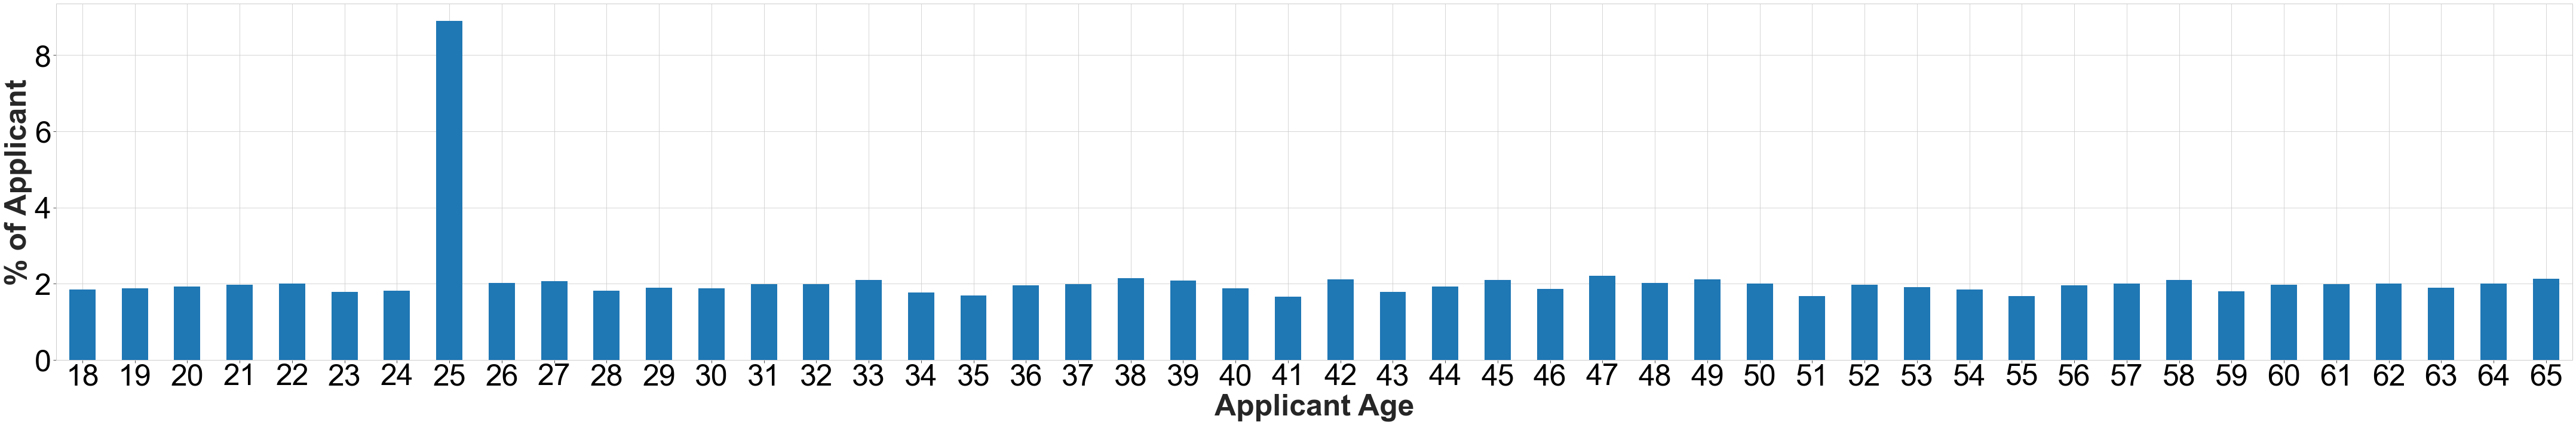

In [34]:
sql = """
select a.age,
  100.0*a.num_applicant/sum(a.num_applicant) over()percent_dist
from(select age, count(age) num_applicant
from oodle_data
group by age)a
order by a.age
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)
df.set_index('age', inplace=True)


line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 



df.plot.bar(color=line_color, legend=False, ax=ax)



ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=50, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/age_dist_across_dataset.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of applicants across our dataset. Most applicants are 25 years old.

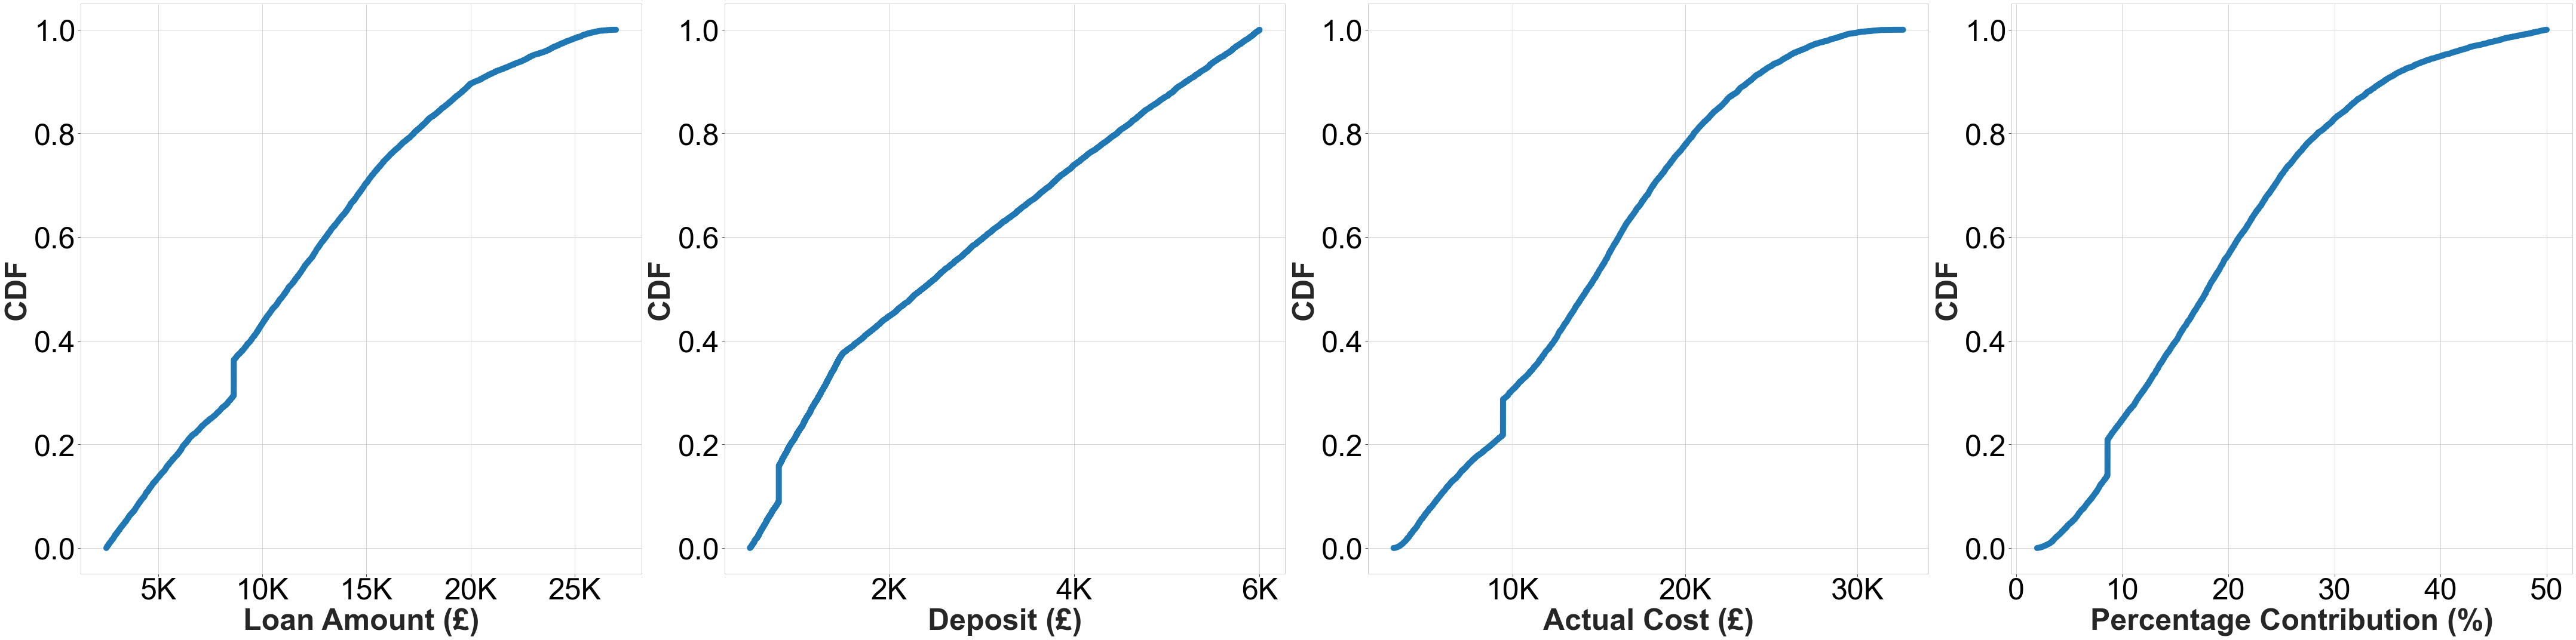

In [37]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
(select area, loan_amount::NUMERIC, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, 'Percentage Contribution' ctr_key
from oodle_data);
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    xdata = np.sort(df_filter.loc[df_filter['ctr_key'] == ctr, 'loan_amount'])
    ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
    ax[i].plot(xdata, ydata, color=line_color[0], lw = 10)
    if ctr in money:
        ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
        ax[i].xaxis.set_major_formatter(formatter)
    else:
        ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
    ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
    ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
    ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_amounts.pdf",  bbox_inches="tight")


The figure above shows the cummulative distribution of loan amount, deposit, actual cost and percentage contibution across out entire dataset

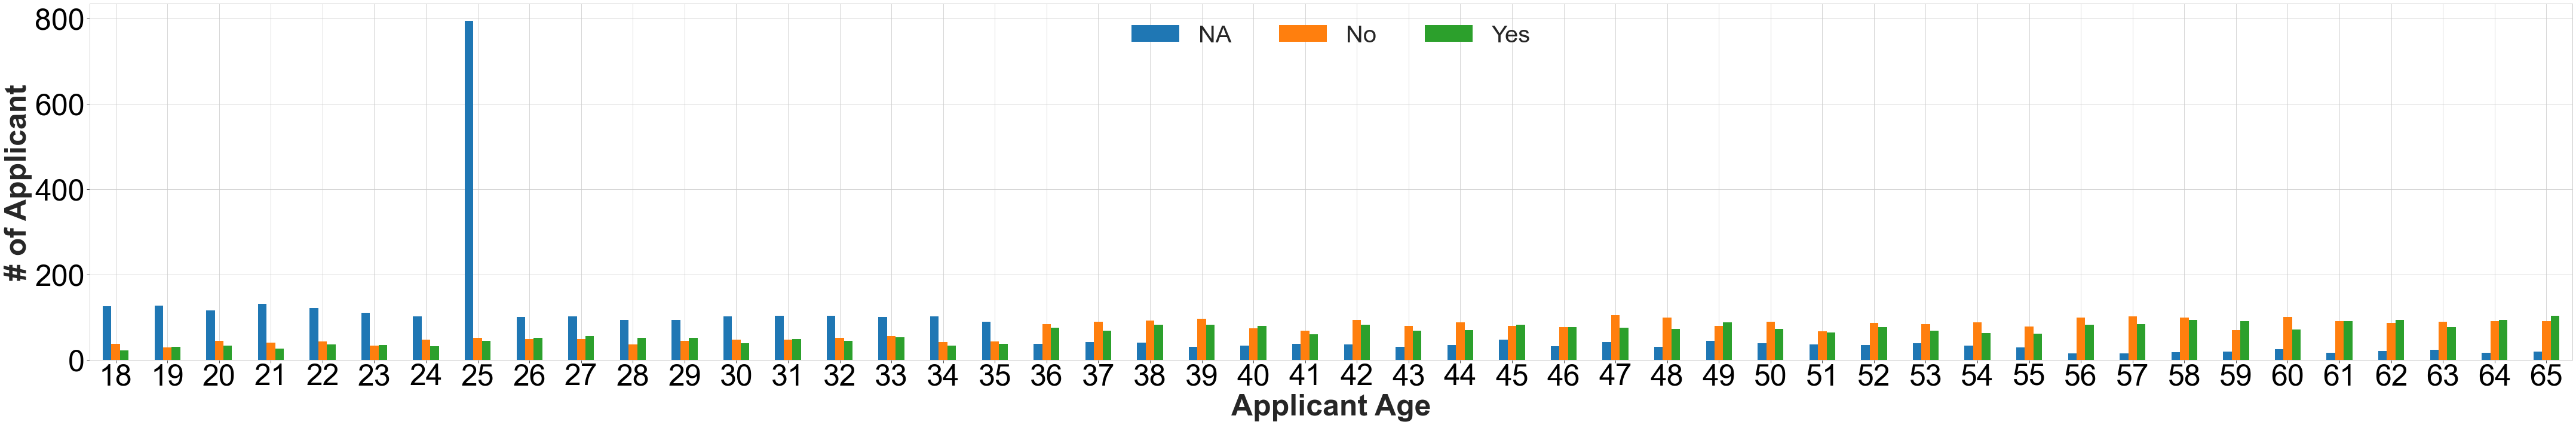

In [35]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
GROUP BY age, funded)a
order by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='num_applicant')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=40, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('# of Applicant', fontsize=50, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/dist_funded_stats_applicant_number.pdf",  bbox_inches="tight")

The graph above is computed by counting the number of applicant in each age group. Almost 800 applicants of age 25 had their loan application request declined.


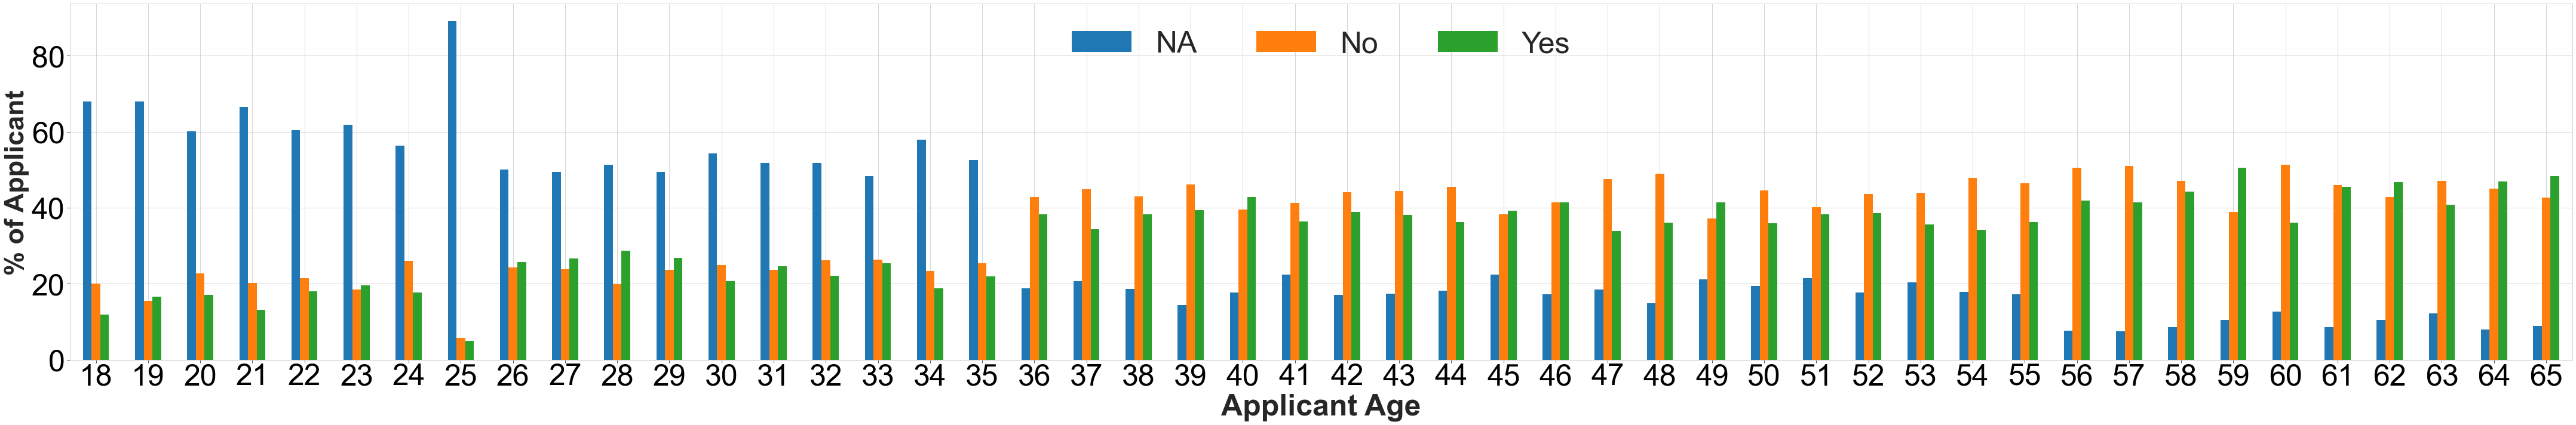

In [36]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
GROUP BY age, funded)a
order by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/dist_funded_stats_applicant_percent.pdf",  bbox_inches="tight")

Same as above but the metric on the Y-axis is computed on percentages. So, we compute the percentage distribution of loan application status for each age group.

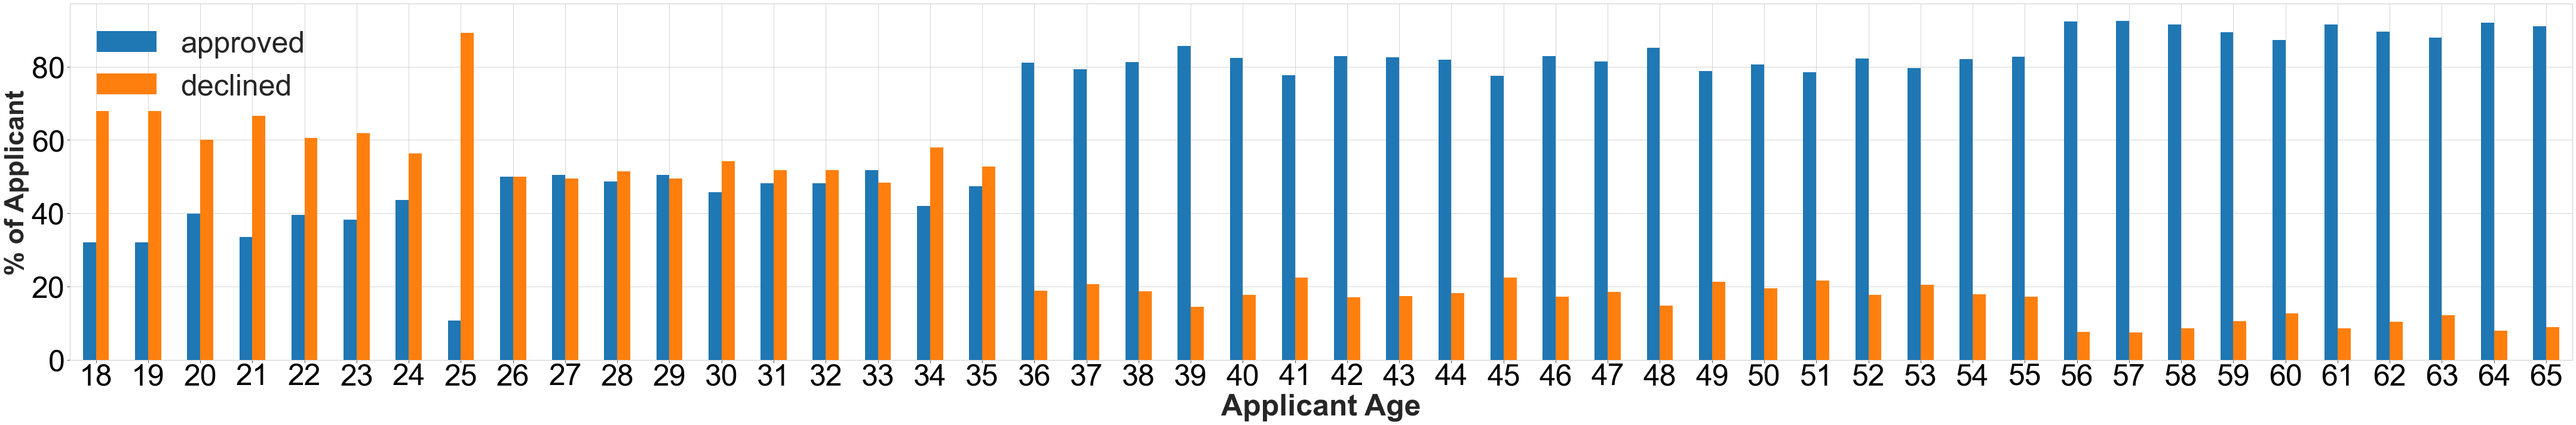

In [6]:
sql = """
select a.age, a.application_outcome, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, application_outcome ,count(id) num_applicant
from oodle_data
group by age, application_outcome)a
order  by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='application_outcome', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=1)

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_vs_declined_age_group.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of approved and declined loan applications across age. We see that most applicants betwen age 18-35 have their loan application declined compare to those between 36-65, with applicats of age 56 having the highest percentage (91%) of approved applications.

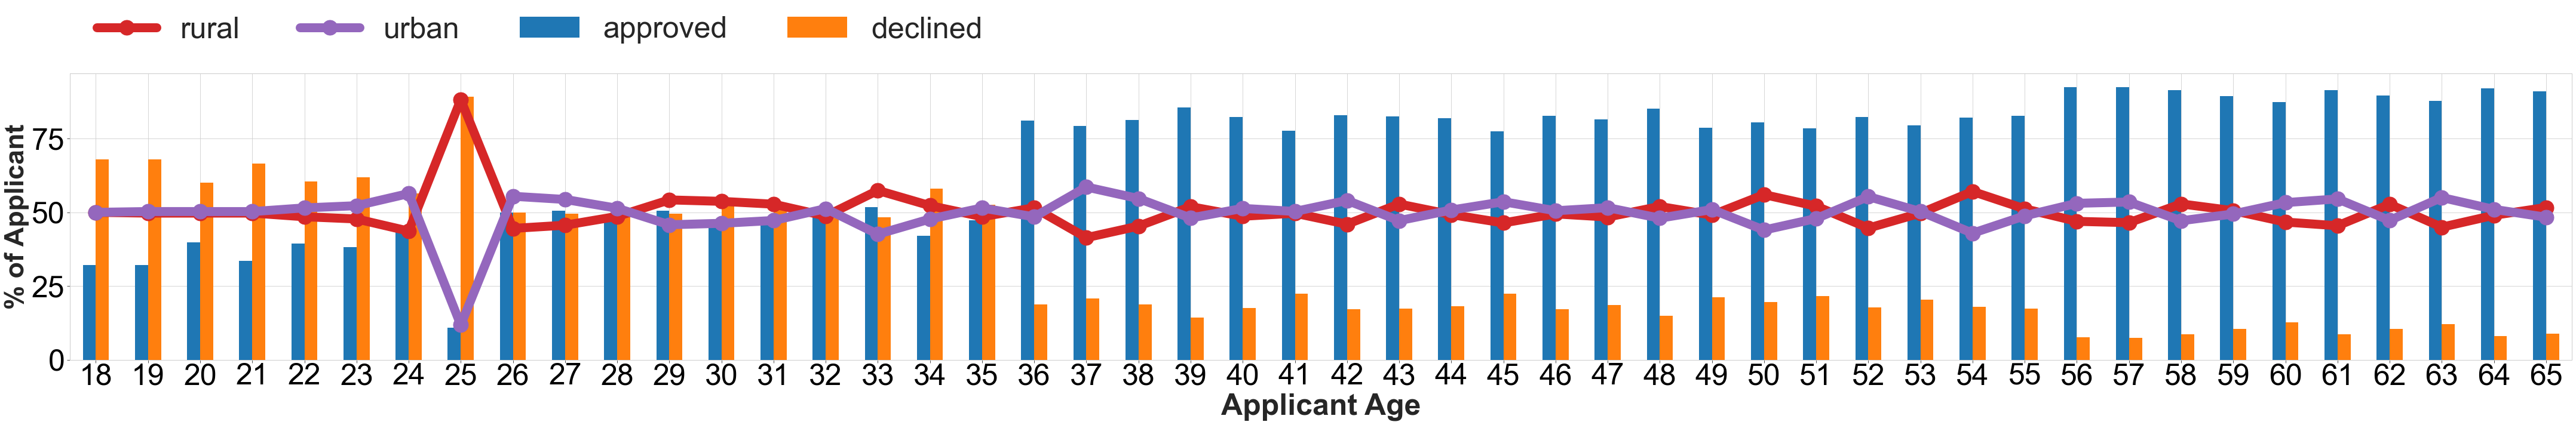

In [20]:
line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
funded_color = ['#d62728', '#9467bd']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

sql = """
select a.age, a.area, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, area, count(age) num_applicant
from oodle_data
GROUP BY age, area)a
order by 1
"""
df_funded = pd.read_sql(sql, conn)
df_funded['age'] = df_funded['age'].astype(int)
df_funded['age'] = df_funded['age'].astype(str)



#####line graph
df_funded = df_funded.pivot(index='age', columns='area', values='percent_dist')
df_funded.plot(color=funded_color, ax=ax, legend=False, markersize=25, lw=15, marker='o')



sql = """
select a.age, a.application_outcome, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, application_outcome ,count(id) num_applicant
from oodle_data
group by age, application_outcome)a
order  by 1 asc
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

df = df.pivot(index='age', columns='application_outcome', values='percent_dist')


df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=5, loc='lower left', bbox_to_anchor= (0.0, 1.01))

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_vs_declined_age_group_area.pdf",  bbox_inches="tight")


The figure above ahow the percentage distibution of loan applications that are approved and declined (bar plots) and the applicants that live in urban and rural areas (line plots). Something interesting happening with applicants of age 25

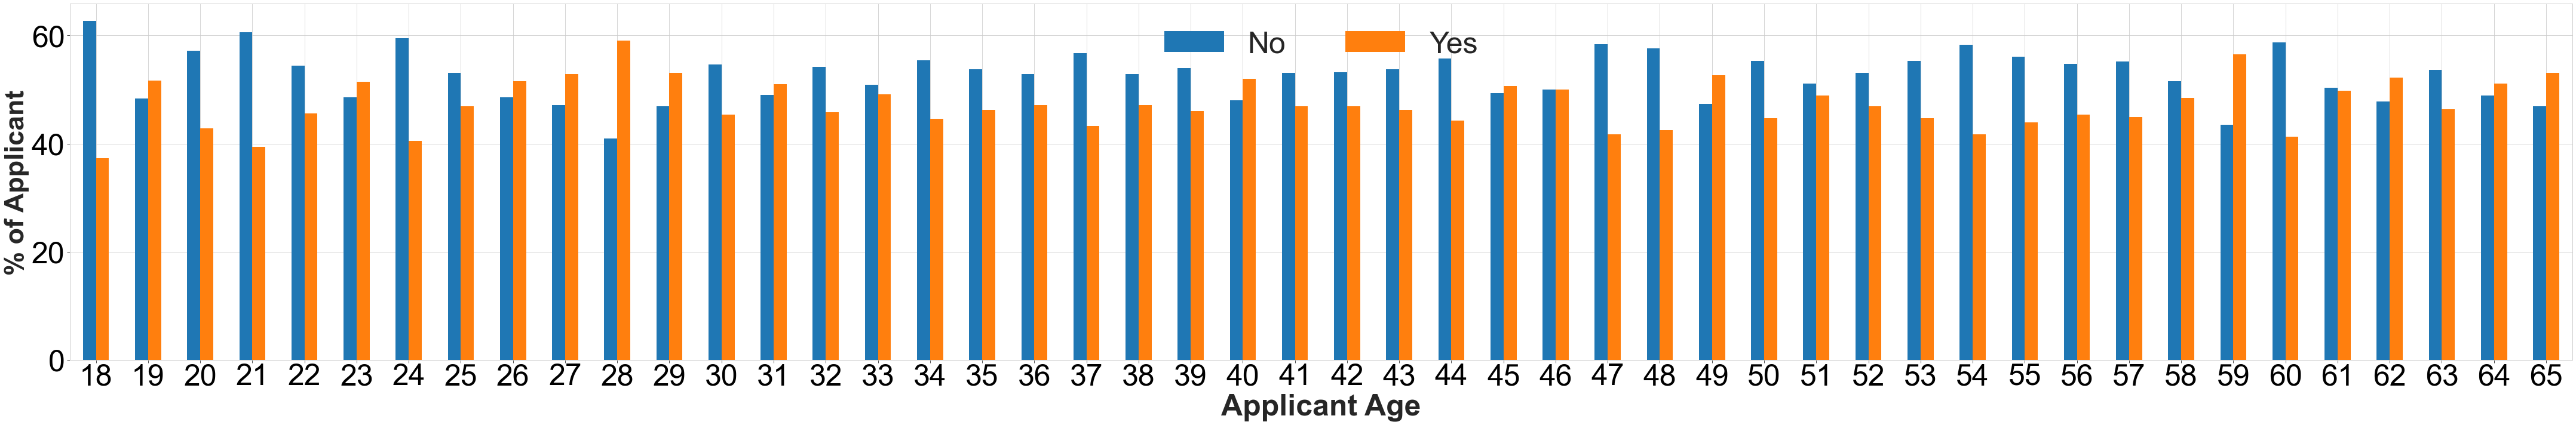

In [8]:
sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, funded)a
order by 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='funded', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_loans_funded_status.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of <b>approved</b> loan applications that are funded and not-funded across each age. We se that across most age approved loans are not disbursed.

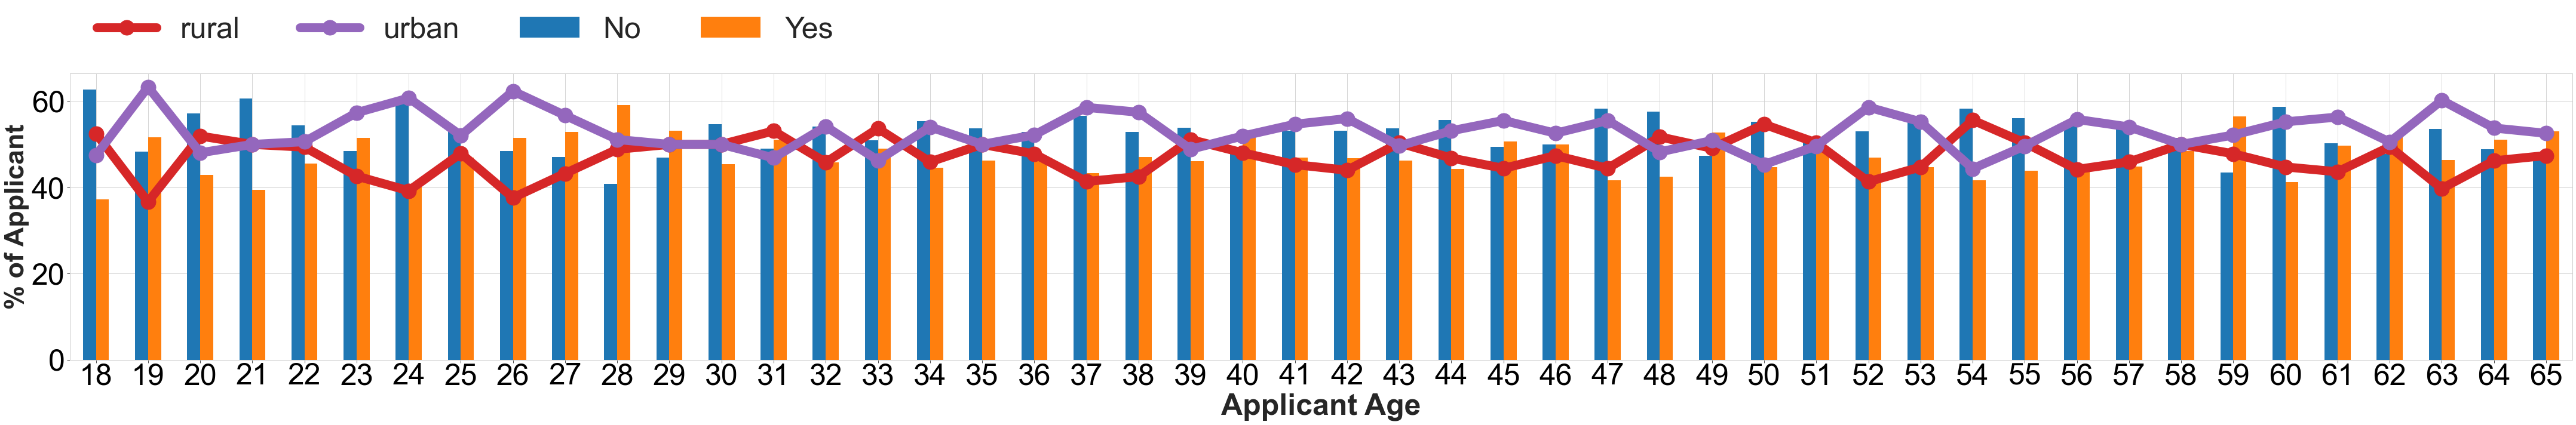

In [21]:
line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
funded_color = ['#d62728', '#9467bd']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

sql = """
select a.age, a.area, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, area, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, area)a
order by 1
"""
df_funded = pd.read_sql(sql, conn)
df_funded['age'] = df_funded['age'].astype(int)
df_funded['age'] = df_funded['age'].astype(str)



#####line graph
df_funded = df_funded.pivot(index='age', columns='area', values='percent_dist')
df_funded.plot(color=funded_color, ax=ax, legend=False, markersize=25, lw=15, marker='o')



sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, funded)a
order by 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)


df = df.pivot(index='age', columns='funded', values='percent_dist')



df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=5, loc='lower left', bbox_to_anchor= (0.0, 1.01))


ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_approved_loans_funded_status_area.pdf",  bbox_inches="tight")


The graph above shows the percentage distribution of <b>approved</b> loan application that were funded and not funded (bar graphs) and the area location where applicants reside (line graph). Rural areas (red line) and urban areas (purple line)

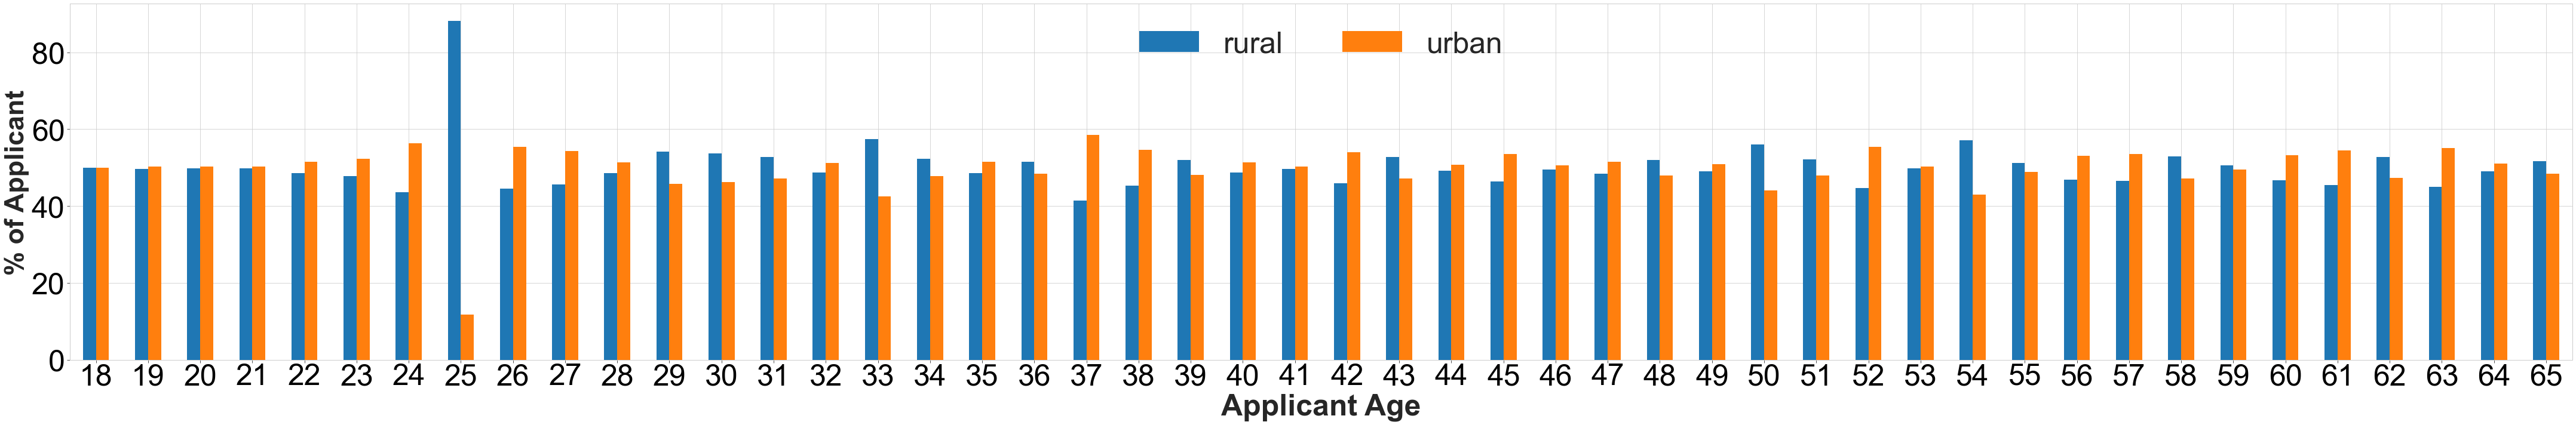

In [9]:
sql = """
select a.age, a.area, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, area, count(age) num_applicant
from oodle_data
GROUP BY age, area)a
order by 1
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='area', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/urban_vs_rural_areas_age_dist.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of applicants that live in either rural and urban areas. Interestingly, there are more more applicants of age 25 living in rural areas.

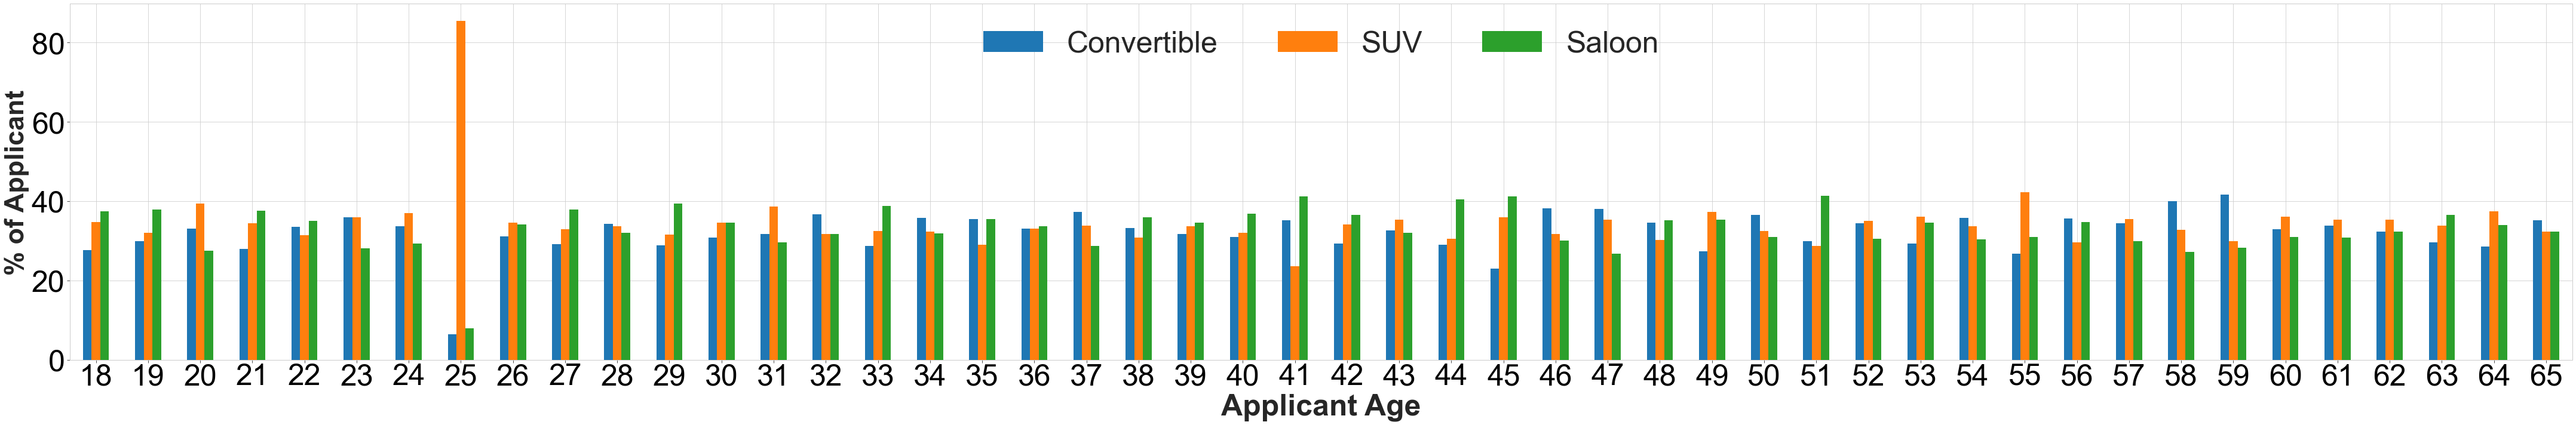

In [2]:
sql = """
select a.age, a.car_type, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, car_type, count(age) num_applicant
from oodle_data
group by age, car_type)a
ORDER BY 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)

df = df.pivot(index='age', columns='car_type', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_of_aplicants_car_type_across_age.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of applicants across car types for each age. Yet again, most applicants of age 25 (>80%) apply for loans to buy a SUV.

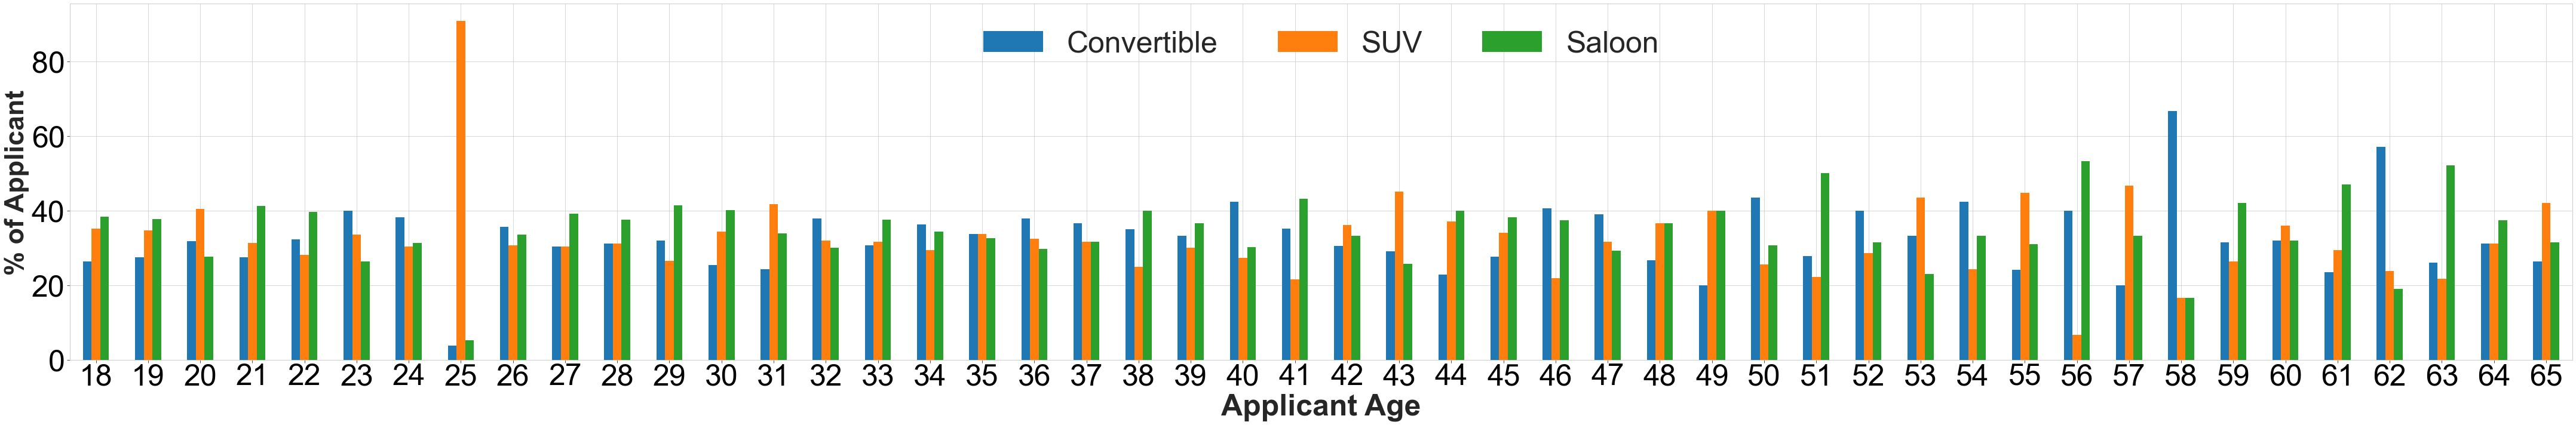

In [5]:
sql = """
select a.age, a.car_type, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, car_type, count(age) num_applicant
from oodle_data
where application_outcome = 'declined'
group by age, car_type)a
ORDER BY 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)


df = df.pivot(index='age', columns='car_type', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_of_aplicants_car_type_across_age_declined.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of applicants across car types for each age for applications that were <b>declined</b>. Most declined loan types are from applicants of age 25 applying to purchase an SUV. However, we see a significant fraction declined loans for 58 and 62 years old.

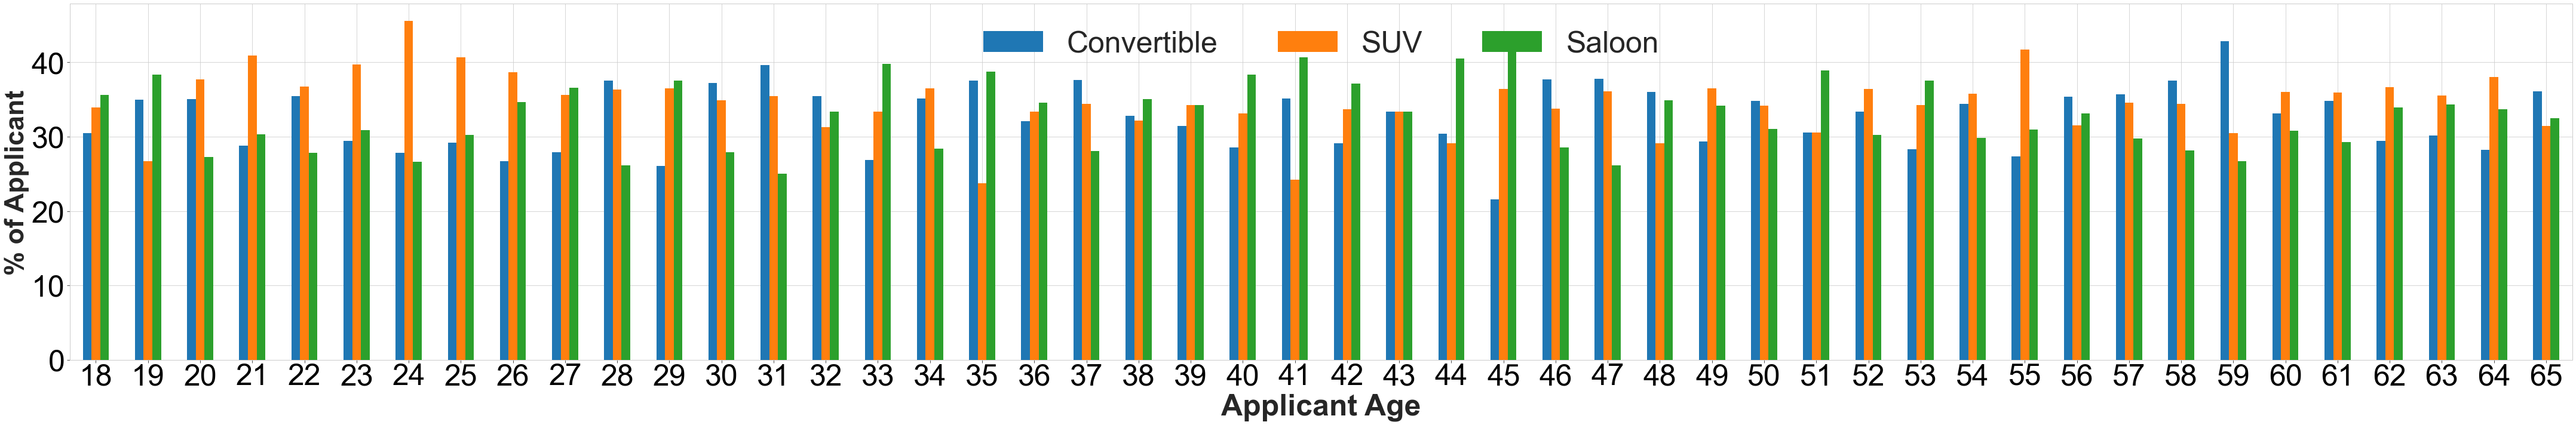

In [6]:
sql = """
select a.age, a.car_type, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, car_type, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
group by age, car_type)a
ORDER BY 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)


df = df.pivot(index='age', columns='car_type', values='percent_dist')

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 


#df.set_index('age', inplace=True)

df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=4, loc='upper center')

ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_of_aplicants_car_type_across_age_approved.pdf",  bbox_inches="tight")

The figure above shows the percentage distribution of applicants across car types for each age for applications that were <b>approved</b>. Most approved loans are for SUV's amongst 24 year olds followed by Saloon's in 45 yers and convertibles in 59 years

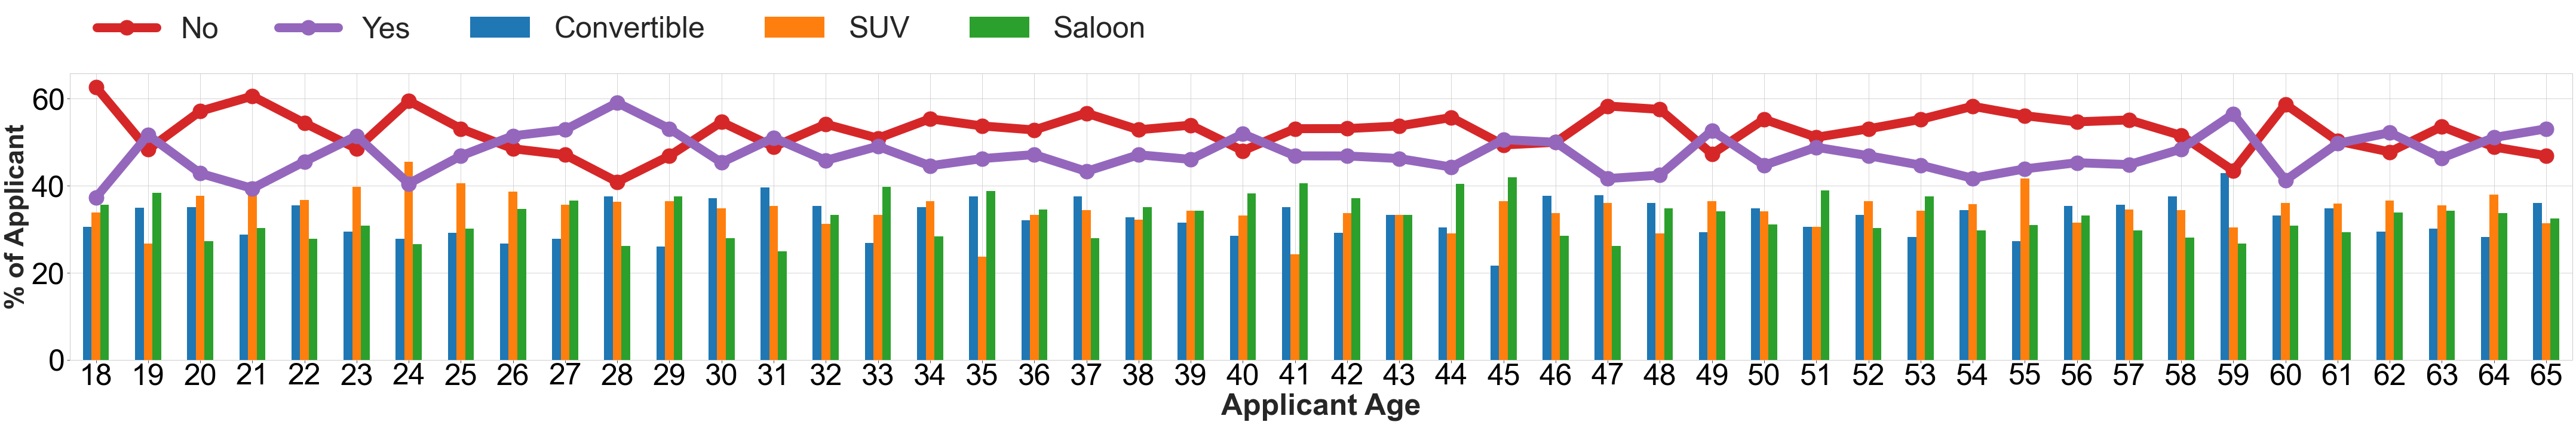

In [17]:
line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
funded_color = ['#d62728', '#9467bd']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

sql = """
select a.age, a.funded, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, funded, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, funded)a
order by 1 asc;
"""
df_funded = pd.read_sql(sql, conn)
df_funded['age'] = df_funded['age'].astype(int)
df_funded['age'] = df_funded['age'].astype(str)



#####line graph
df_funded = df_funded.pivot(index='age', columns='funded', values='percent_dist')
df_funded.plot(color=funded_color, ax=ax, legend=False, markersize=25, lw=15, marker='o')



sql = """
select a.age, a.car_type, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, car_type, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
group by age, car_type)a
ORDER BY 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)


df = df.pivot(index='age', columns='car_type', values='percent_dist')



df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=5, loc='lower left', bbox_to_anchor= (0.0, 1.01))


ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_of_aplicants_car_type_across_age_approved_funded.pdf",  bbox_inches="tight")


The figure above shows the percentage distribution of applicants across car types for each age for applications that were <b>approved</b>. The line graph shows the percentage of applicants that have their application funded (purple line) and not funced (red line)

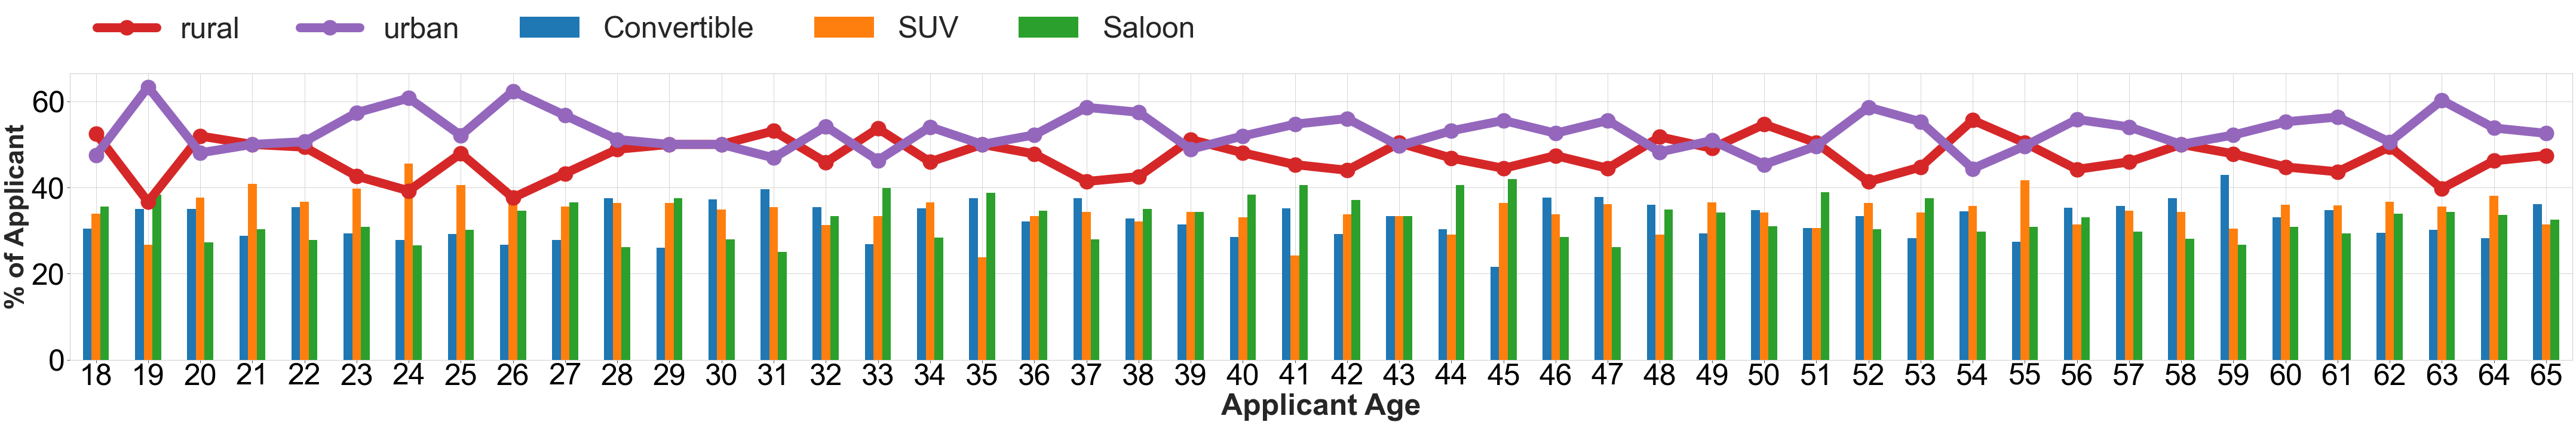

In [18]:
line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
funded_color = ['#d62728', '#9467bd']
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

sql = """
select a.age, a.area, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(select age, area, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
GROUP BY age, area)a
order by 1
"""
df_funded = pd.read_sql(sql, conn)
df_funded['age'] = df_funded['age'].astype(int)
df_funded['age'] = df_funded['age'].astype(str)



#####line graph
df_funded = df_funded.pivot(index='age', columns='area', values='percent_dist')
df_funded.plot(color=funded_color, ax=ax, legend=False, markersize=25, lw=15, marker='o')



sql = """
select a.age, a.car_type, a.num_applicant,
  100.00*a.num_applicant/sum(a.num_applicant) over(PARTITION BY age) percent_dist
from(SELECT age, car_type, count(age) num_applicant
from oodle_data
where application_outcome = 'approved'
group by age, car_type)a
ORDER BY 1 asc;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)


df = df.pivot(index='age', columns='car_type', values='percent_dist')



df.plot.bar(color=line_color, legend=False, ax=ax)
h1, l1 = ax.get_legend_handles_labels()


ax.legend(h1, l1, fontsize=50, ncol=5, loc='lower left', bbox_to_anchor= (0.0, 1.01))


ax.set_xlabel('Applicant Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% of Applicant', fontsize=45, fontweight="bold")


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/percent_dist_of_aplicants_car_type_across_age_approved_area.pdf",  bbox_inches="tight")


The figure above shows the percentage distribution of applicants across car types for each age for applications that were <b>approved</b>. The line graph shows the percentage of applicants thatlibe in an urban area (purple line) and rural area (red line)

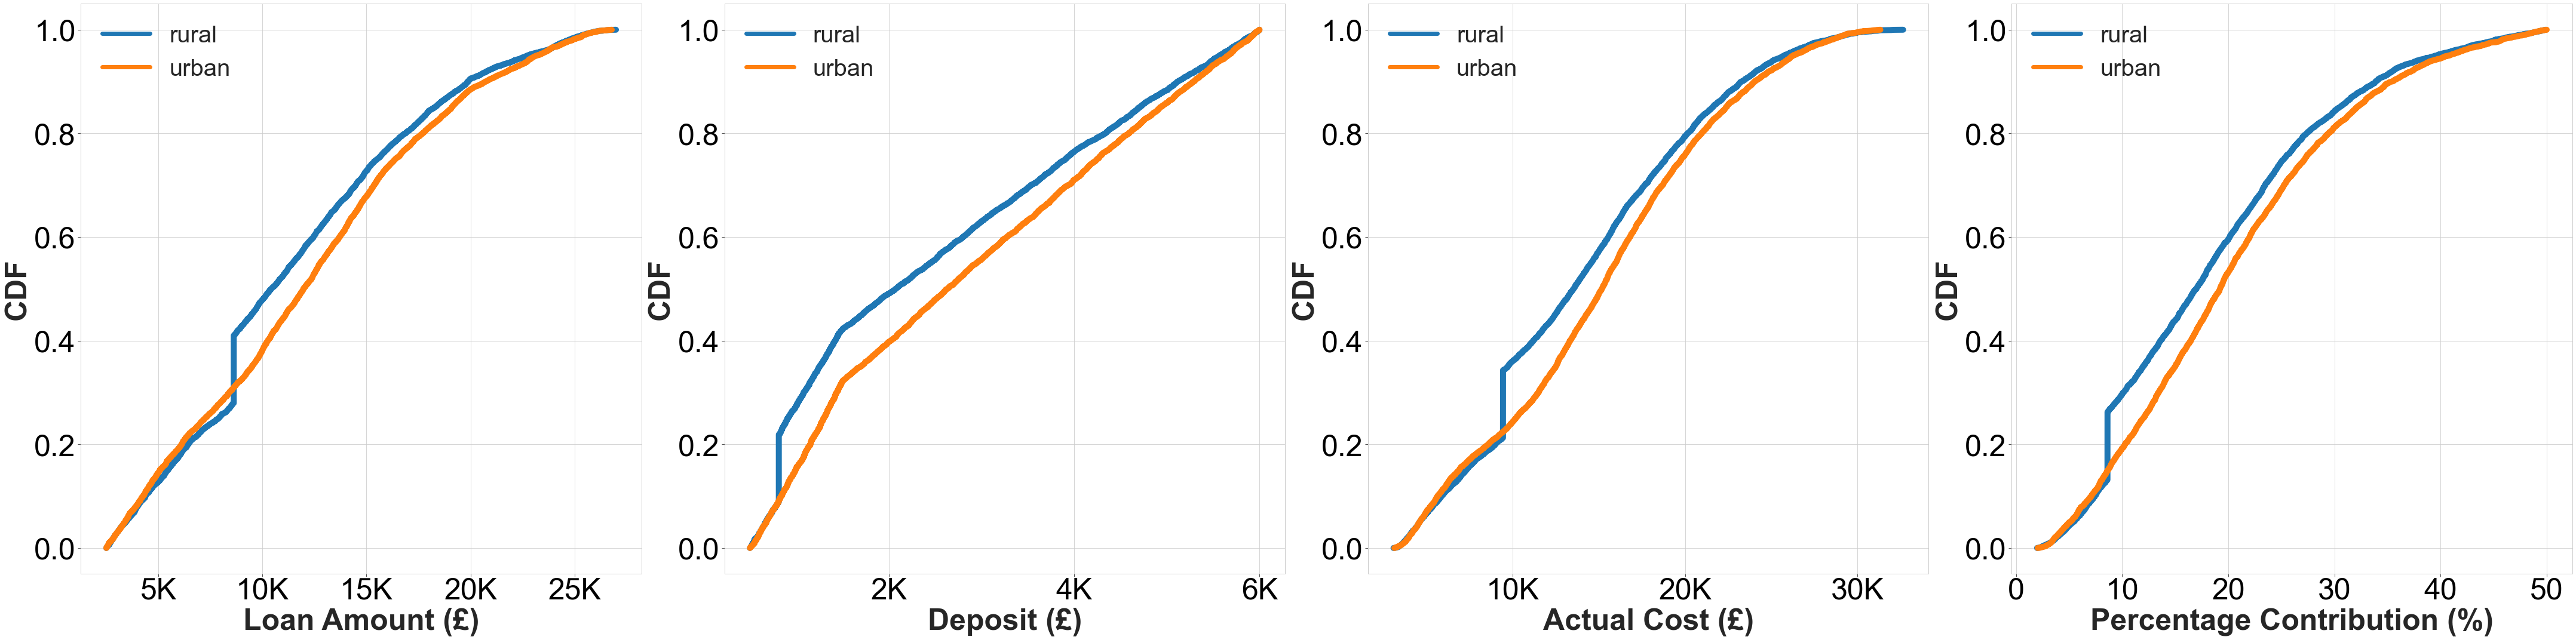

In [28]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
(select area, loan_amount::NUMERIC, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, 'Percentage Contribution' ctr_key
from oodle_data);
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    leg_1 = []
    for a in area:
        xdata = np.sort(df_filter.loc[df_filter['area'] == a, 'loan_amount'])
        ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
        ax[i].plot(xdata, ydata, color=line_color[c], lw = 10)
        leg_1.append(mlines.Line2D([], [], color=line_color[c], markersize=10, label=a, lw=7)) 
        ax[i].legend(handles=leg_1, fontsize=40, ncol=1)
        if ctr in money:
            ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
            ax[i].xaxis.set_major_formatter(formatter)
        else:
            ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
        ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
        ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
        ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        c+=1
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_areas_for_loan_amt_and_co.pdf",  bbox_inches="tight")


The graph above shows the cummulative distribution of applicants in rural and urban areas across loan amount, deopits, actual cost and percentage contribution. We compute the actual cost by adding the loan amount anf the deposit (loan amount + deposit) and the percentage contibution  by (deposit/(loan amount + deposit)) * 100.

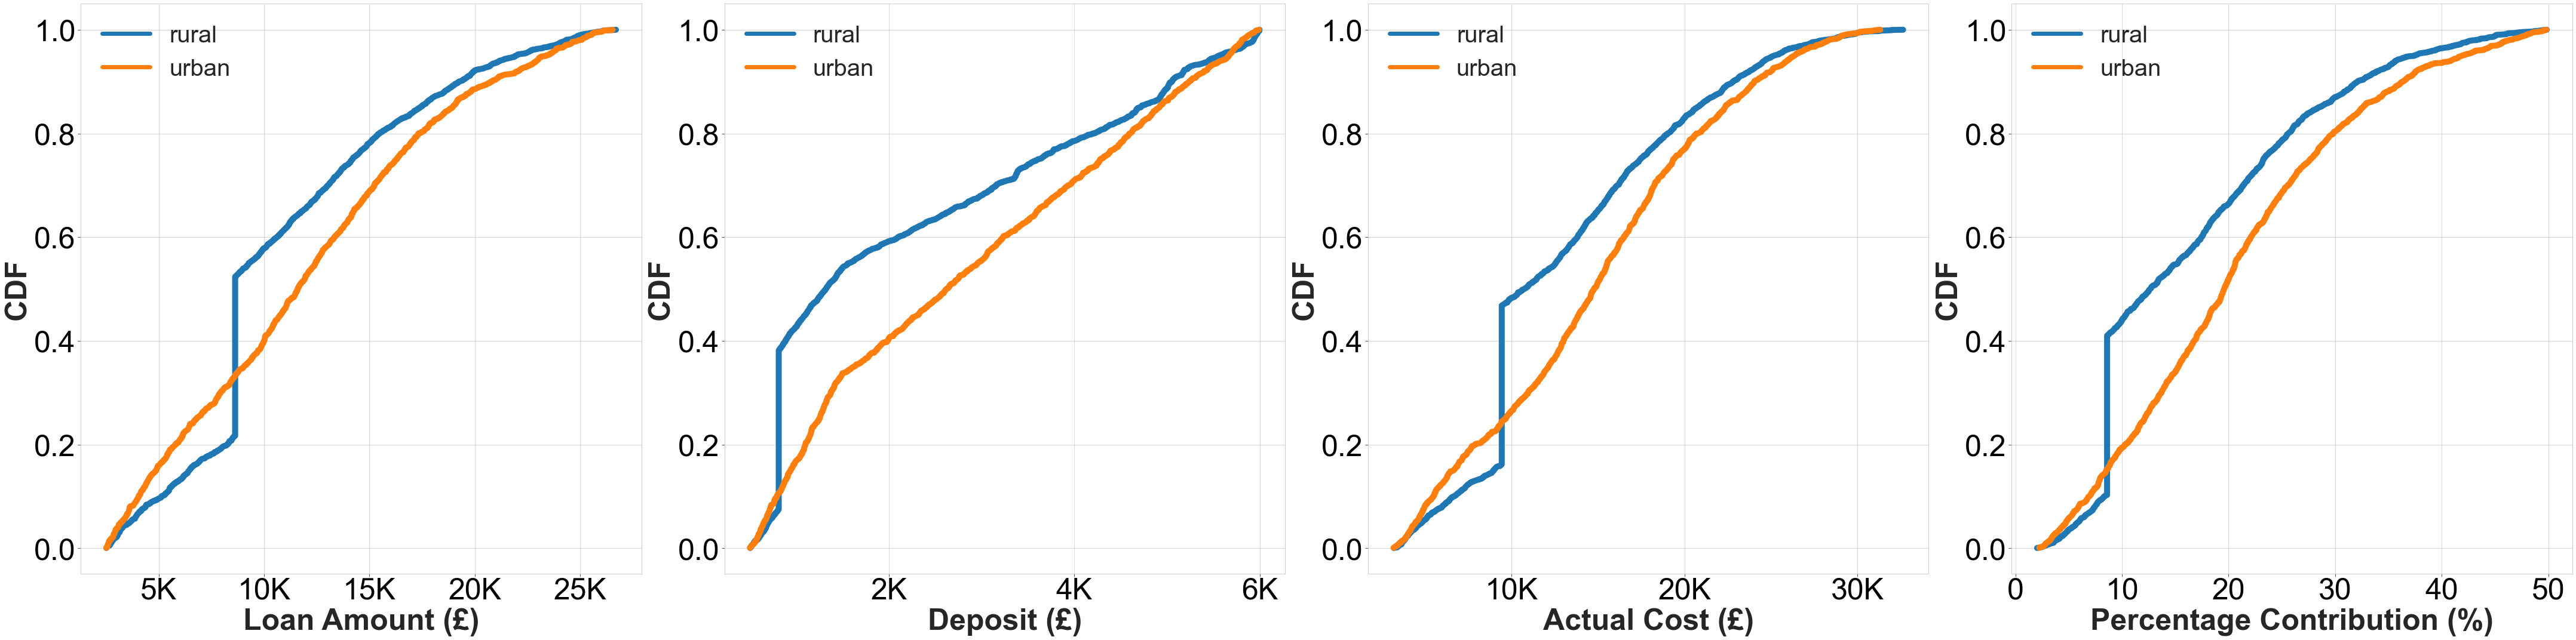

In [30]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
select a.area, a.loan_amount, a.ctr_key
from((select area, loan_amount::NUMERIC, application_outcome, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, application_outcome, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, application_outcome, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, application_outcome, 'Percentage Contribution' ctr_key
from oodle_data))a
WHERE a.application_outcome = 'declined'
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    leg_1 = []
    for a in area:
        xdata = np.sort(df_filter.loc[df_filter['area'] == a, 'loan_amount'])
        ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
        ax[i].plot(xdata, ydata, color=line_color[c], lw = 10)
        leg_1.append(mlines.Line2D([], [], color=line_color[c], markersize=10, label=a, lw=7)) 
        ax[i].legend(handles=leg_1, fontsize=40, ncol=1)
        if ctr in money:
            ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
            ax[i].xaxis.set_major_formatter(formatter)
        else:
            ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
        ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
        ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
        ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        c+=1
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_areas_for_loan_amt_and_co_declined.pdf",  bbox_inches="tight")


The figure above showed the cummulative distribution of applicants that have their loan application <b>declined</b> across loan amount, deposit, actual cost and percentage contribution.

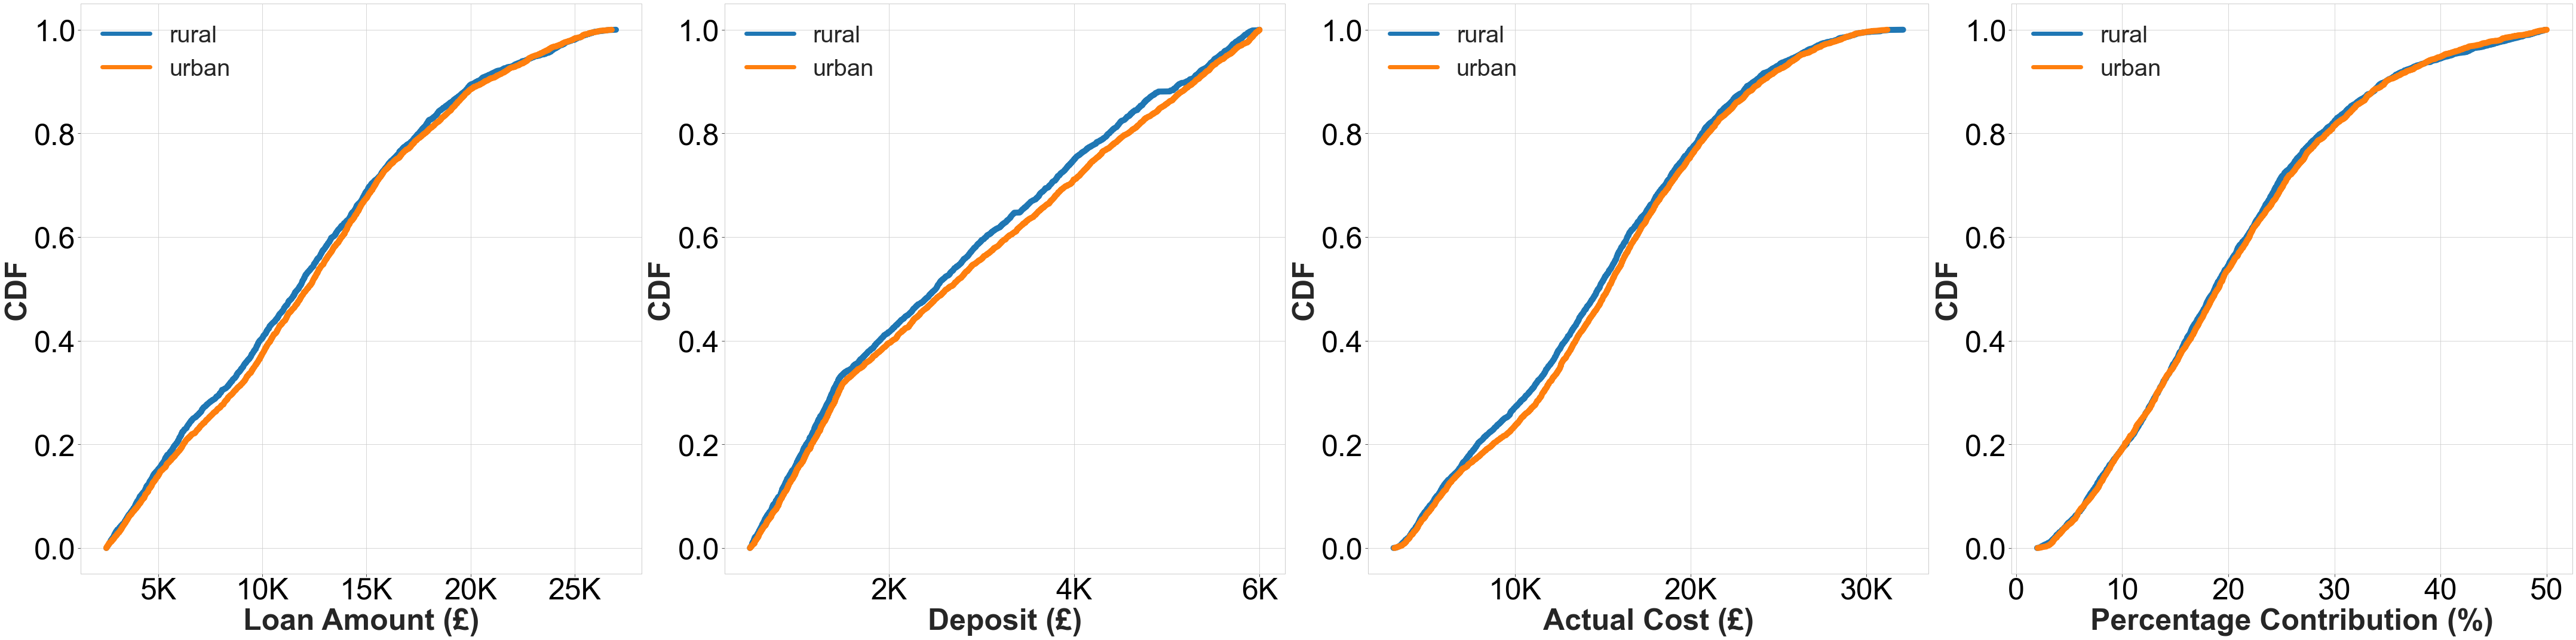

In [31]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
select a.area, a.loan_amount, a.ctr_key
from((select area, loan_amount::NUMERIC, application_outcome, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, application_outcome, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, application_outcome, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, application_outcome, 'Percentage Contribution' ctr_key
from oodle_data))a
WHERE a.application_outcome = 'approved'
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    leg_1 = []
    for a in area:
        xdata = np.sort(df_filter.loc[df_filter['area'] == a, 'loan_amount'])
        ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
        ax[i].plot(xdata, ydata, color=line_color[c], lw = 10)
        leg_1.append(mlines.Line2D([], [], color=line_color[c], markersize=10, label=a, lw=7)) 
        ax[i].legend(handles=leg_1, fontsize=40, ncol=1)
        if ctr in money:
            ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
            ax[i].xaxis.set_major_formatter(formatter)
        else:
            ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
        ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
        ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
        ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        c+=1
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_areas_for_loan_amt_and_co_approved.pdf",  bbox_inches="tight")


The figure above showed the cummulative distribution of applicants that have their loan application <b>approved</b> across loan amount, deposit, actual cost and percentage contribution.

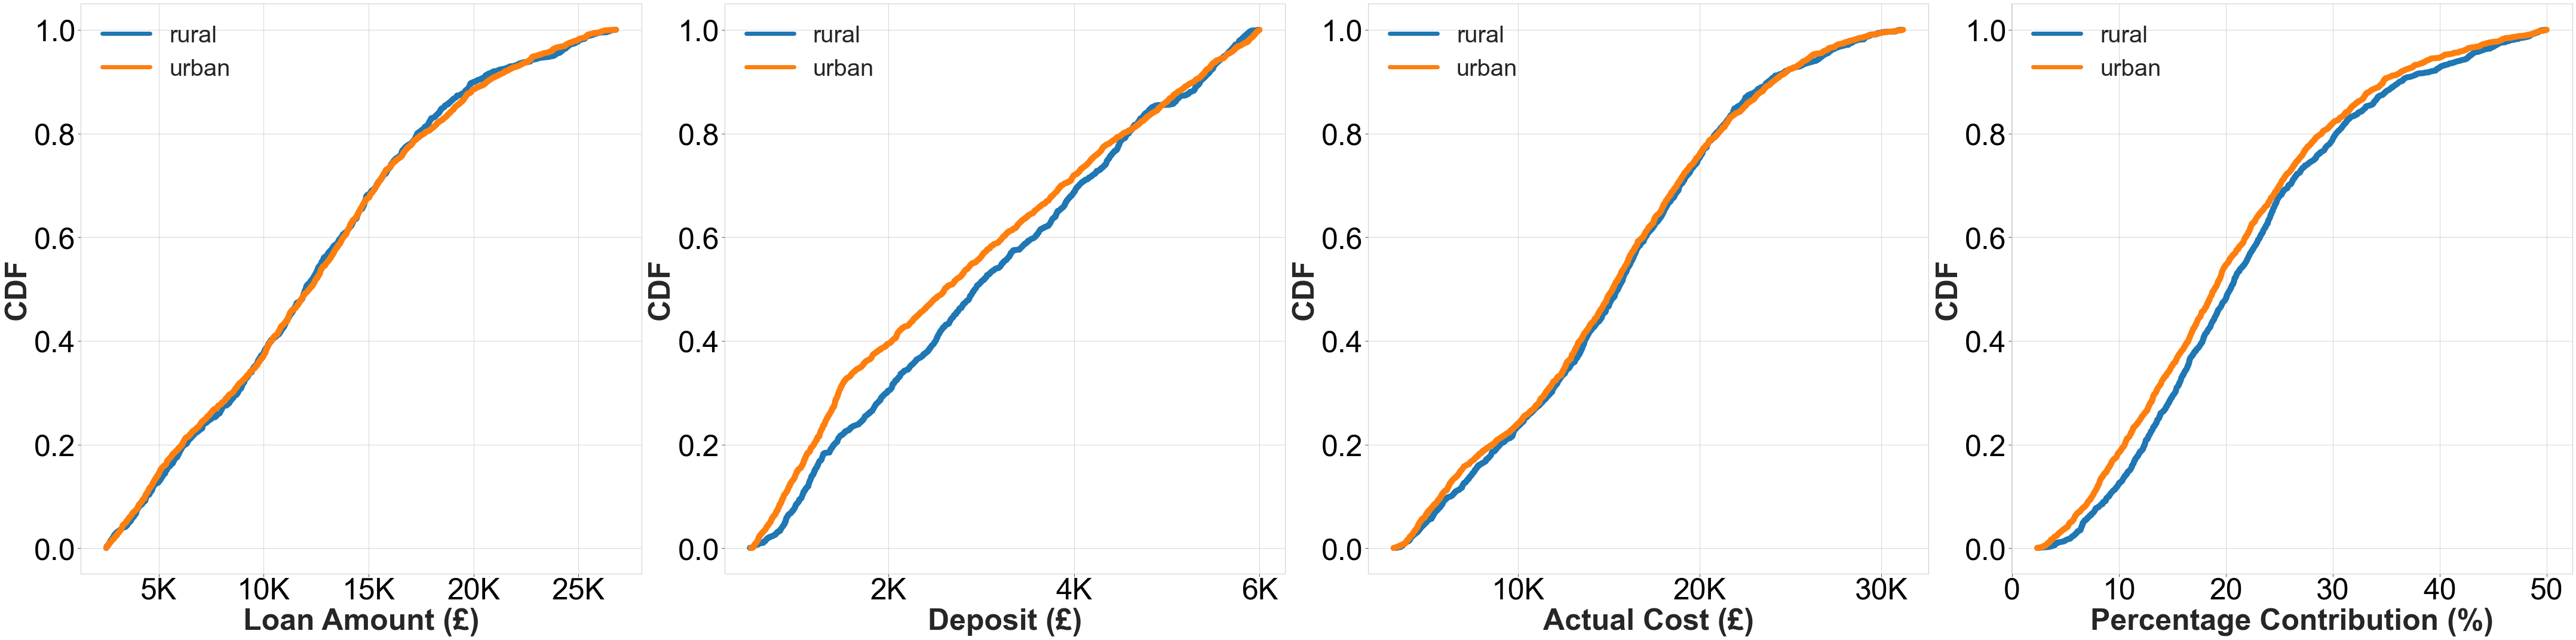

In [32]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
select a.area, a.loan_amount, a.ctr_key
from((select area, loan_amount::NUMERIC, application_outcome, funded, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, application_outcome, funded, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, application_outcome, funded, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, application_outcome, funded, 'Percentage Contribution' ctr_key
from oodle_data))a
WHERE a.application_outcome = 'approved'
and a.funded = 'Yes'
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    leg_1 = []
    for a in area:
        xdata = np.sort(df_filter.loc[df_filter['area'] == a, 'loan_amount'])
        ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
        ax[i].plot(xdata, ydata, color=line_color[c], lw = 10)
        leg_1.append(mlines.Line2D([], [], color=line_color[c], markersize=10, label=a, lw=7)) 
        ax[i].legend(handles=leg_1, fontsize=40, ncol=1)
        if ctr in money:
            ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
            ax[i].xaxis.set_major_formatter(formatter)
        else:
            ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
        ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
        ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
        ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        c+=1
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_areas_for_loan_amt_and_co_approved_funded_yes.pdf",  bbox_inches="tight")


The figure above showed the cummulative distribution of applicants that have their loan application <b>approved</b> and <b> funded </b> across loan amount, deposit, actual cost and percentage contribution.

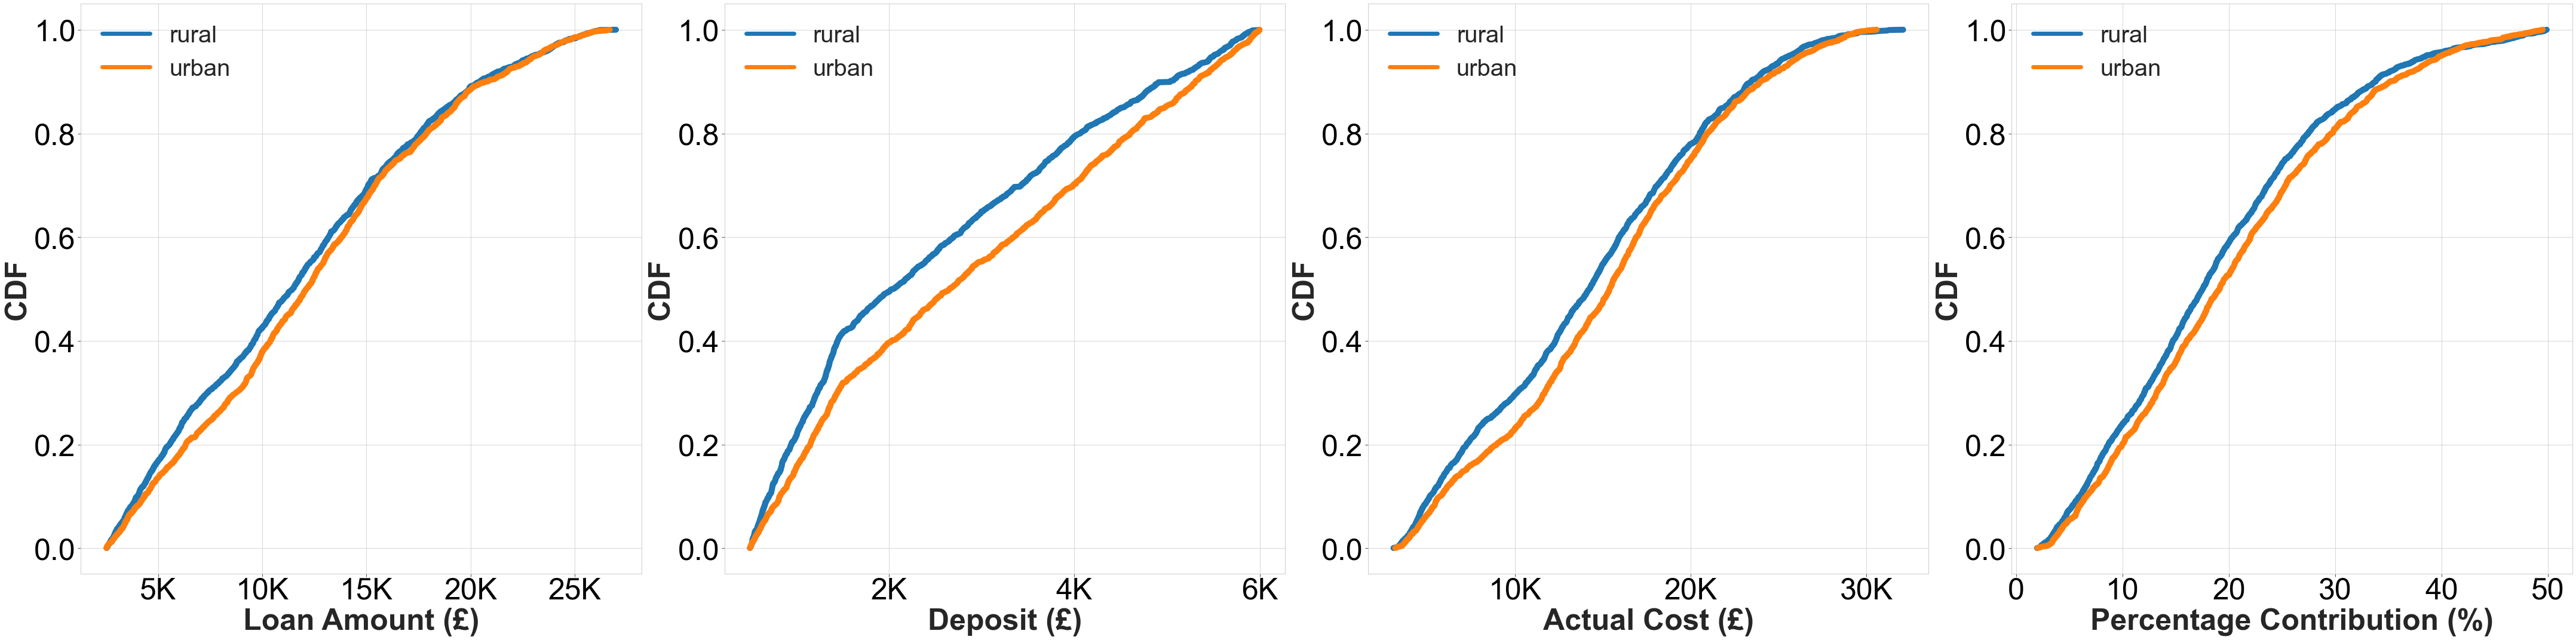

In [33]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 



line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')

ctr_key =['Loan Amount', 'Deposit', 'Actual Cost', 'Percentage Contribution']
money =['Loan Amount', 'Deposit', 'Actual Cost']
area = ['rural', 'urban']

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(60, 15))

formatter = FuncFormatter(hundred)

sql = """
select a.area, a.loan_amount, a.ctr_key
from((select area, loan_amount::NUMERIC, application_outcome, funded, 'Loan Amount' ctr_key
from oodle_data)
UNION ALL
(select area, deposit::NUMERIC, application_outcome, funded, 'Deposit' ctr_key
from oodle_data)
UNION ALL
(select area, (loan_amount + deposit)::NUMERIC as actual_cost, application_outcome, funded, 'Actual Cost' ctr_key
from oodle_data)
UNION ALL
(select area, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib, application_outcome, funded, 'Percentage Contribution' ctr_key
from oodle_data))a
WHERE a.application_outcome = 'approved'
and a.funded = 'No'
"""
df = pd.read_sql(sql, conn)

i=0
for ctr in ctr_key:
    c=0
    df_filter = df.loc[df['ctr_key'] == ctr]
    leg_1 = []
    for a in area:
        xdata = np.sort(df_filter.loc[df_filter['area'] == a, 'loan_amount'])
        ydata = np.arange(1, len(xdata)+1) / float(len(xdata))
        ax[i].plot(xdata, ydata, color=line_color[c], lw = 10)
        leg_1.append(mlines.Line2D([], [], color=line_color[c], markersize=10, label=a, lw=7)) 
        ax[i].legend(handles=leg_1, fontsize=40, ncol=1)
        if ctr in money:
            ax[i].set_xlabel(ctr+' (£)', fontsize=50, fontweight="bold")
            ax[i].xaxis.set_major_formatter(formatter)
        else:
            ax[i].set_xlabel(ctr+' (%)', fontsize=50, fontweight="bold")
        ax[i].set_ylabel('CDF', fontsize=50, fontweight="bold")
        
        ax[i].tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, pad=0.5)
        ax[i].tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)
        c+=1
    i+=1
    
plt.tight_layout()
plt.savefig("figures/cdf_showing_distribution_across_areas_for_loan_amt_and_co_approved_funded_no.pdf",  bbox_inches="tight")


The figure above showed the cummulative distribution of applicants that have their loan application <b>approved</b> and <b> not funded </b> across loan amount, deposit, actual cost and percentage contribution.

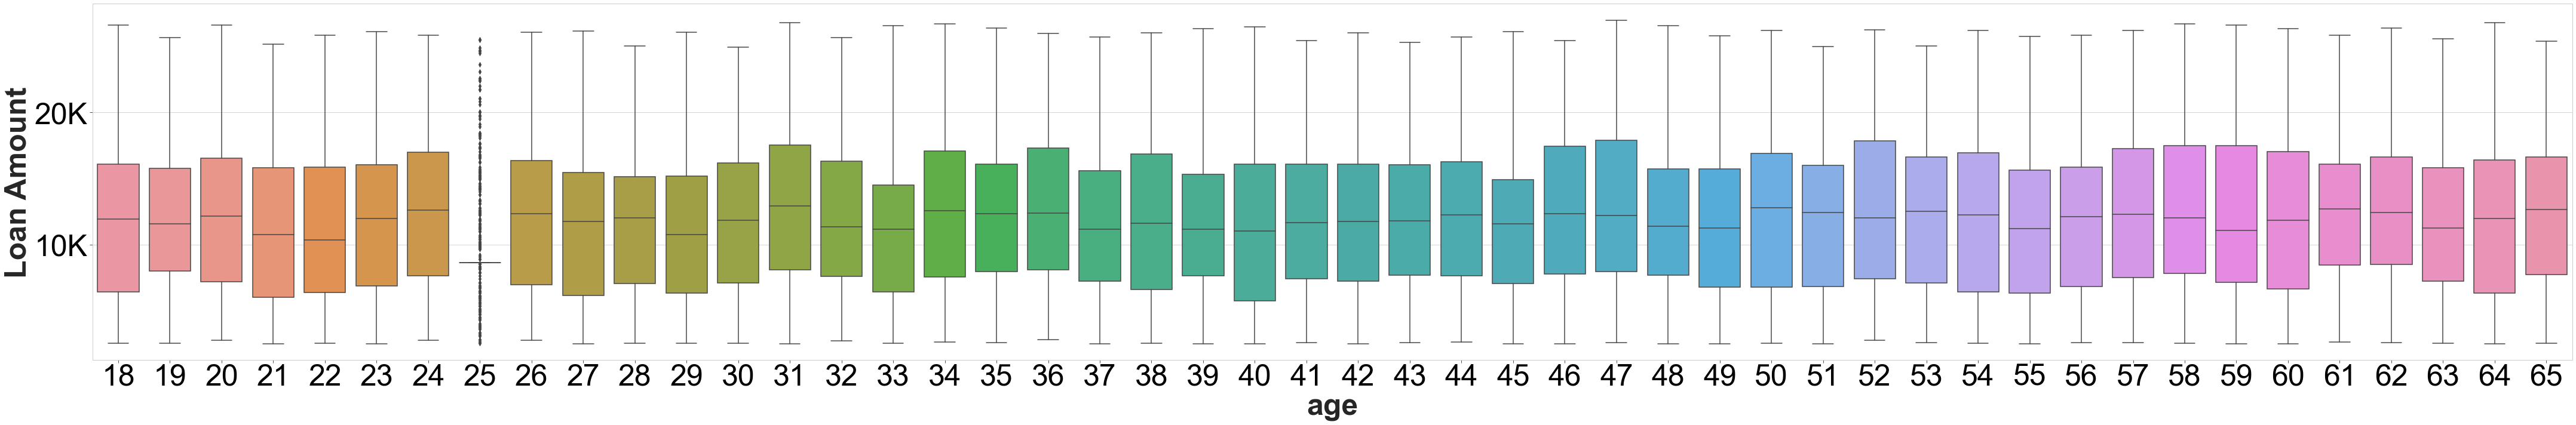

In [60]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, loan_amount:: NUMERIC
from oodle_data;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['loan_amount'], grid = False, ax=ax) 
sns.boxplot(x='age', y='loan_amount', data=df, ax=ax)

    
ax.set_xlabel('age', fontsize=50, fontweight="bold")
ax.set_ylabel('Loan Amount', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_dist_applicants.pdf",  bbox_inches="tight")

The figure above showa a boxplot showing the distribution pf loan amounts across age. Boxplots show the maximum, 3rd quartile (75%), median, 1st quartile (25%) and minimum. To compute the maximum and minimum values, we first calculate the interquartile range which is 3rd quartile - 1st quartile, then the maximum is computed using the formula 3rd quartile + (interquartile range * 1.5) while the minimum is computed using formula 1st quartile - (interquartile range * 1.5). Ponts that appear outside the maximum and minimum range is considered as outliers.

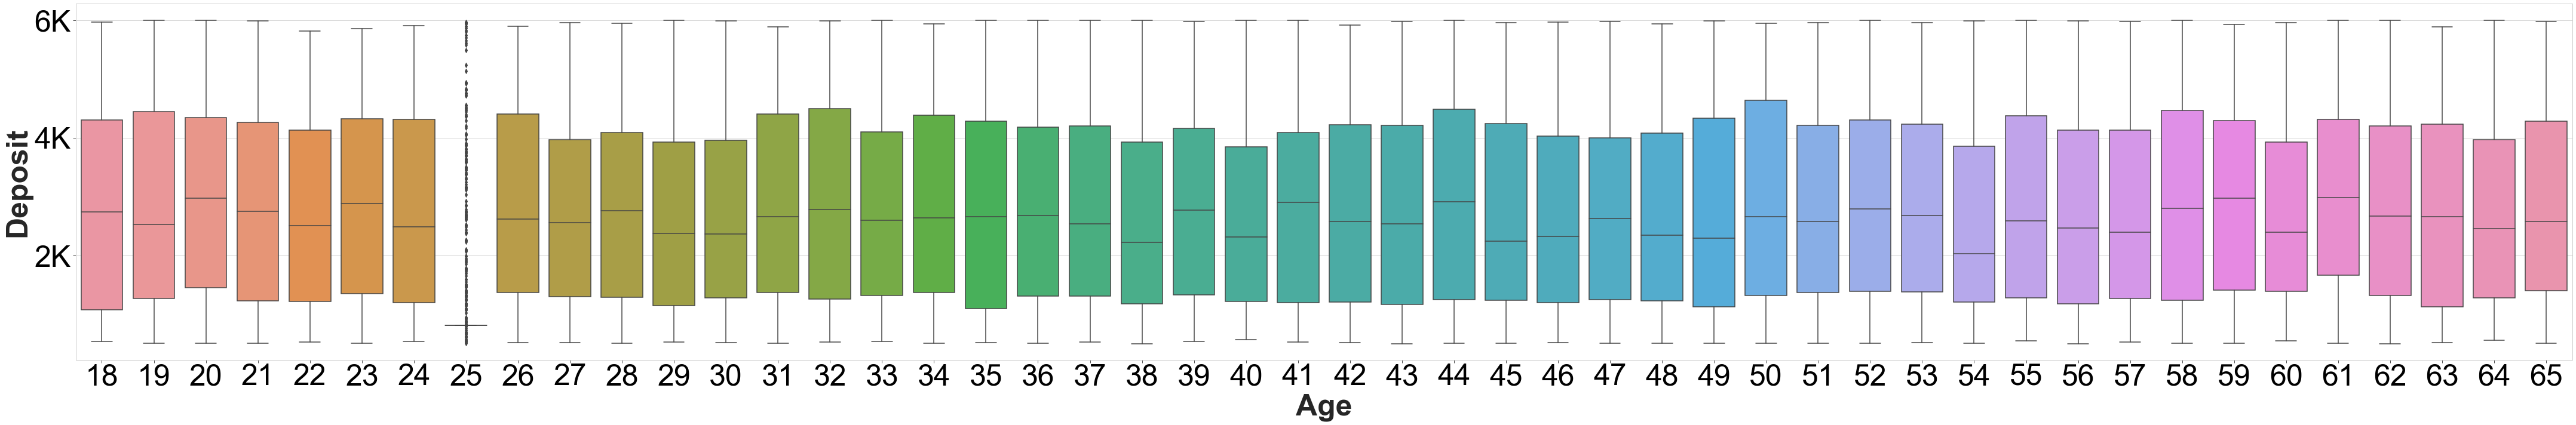

In [59]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, deposit:: NUMERIC
from oodle_data;
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='deposit', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('Deposit', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/deposit_dist_applicants.pdf",  bbox_inches="tight")

Boxplot showing the distribution of deposits across age

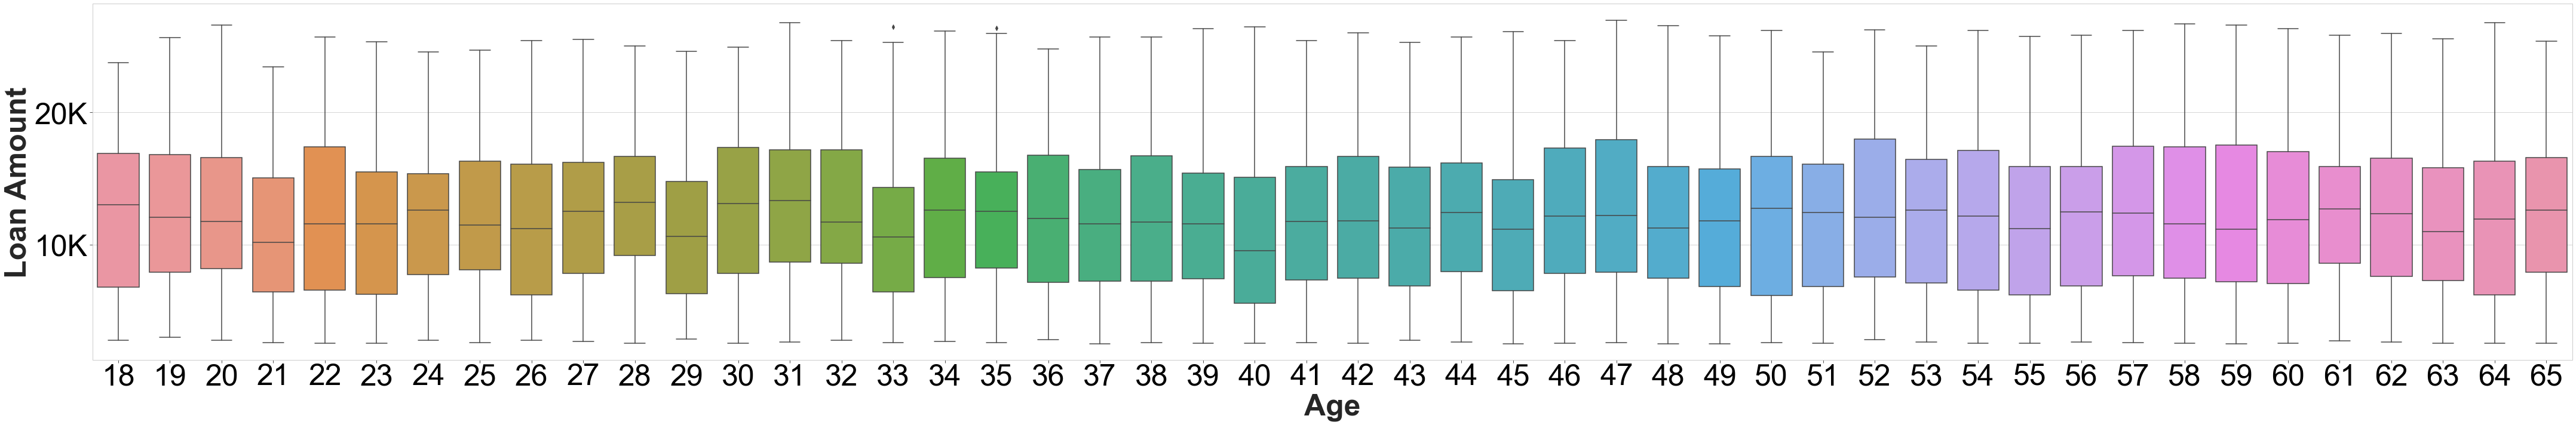

In [64]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, loan_amount:: NUMERIC
from oodle_data
where application_outcome = 'approved'
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='loan_amount', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('Loan Amount', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_applicants_approved.pdf",  bbox_inches="tight")

The figure above shows the distribution of loan amounts that was <b>approved</b>  across each age

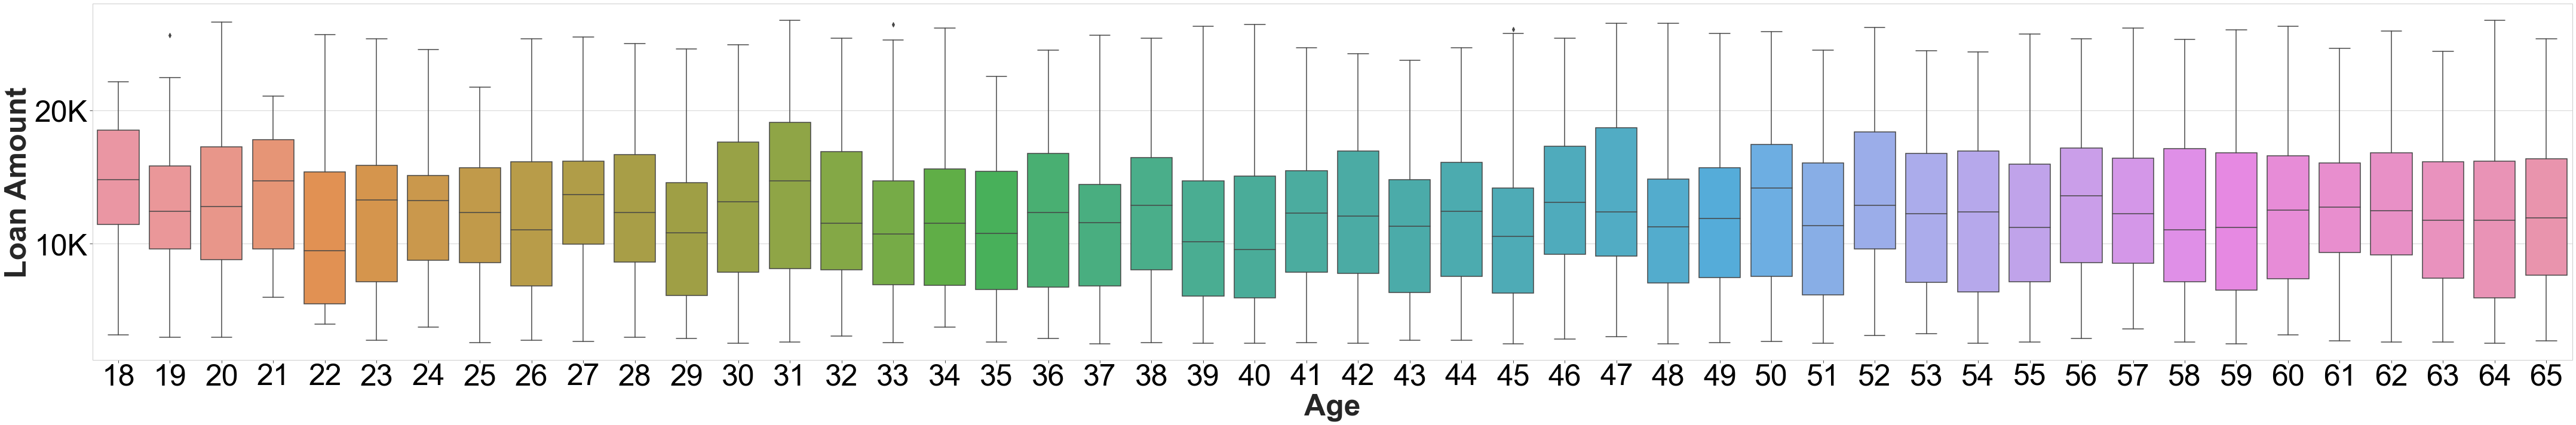

In [65]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, loan_amount:: NUMERIC
from oodle_data
where application_outcome = 'approved'
and funded = 'Yes'
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='loan_amount', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('Loan Amount', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_applicants_approved_funded.pdf",  bbox_inches="tight")

The figure above shows the distribution of loan amounts that was <b>approved</b>  and <b>funded</b> across each age

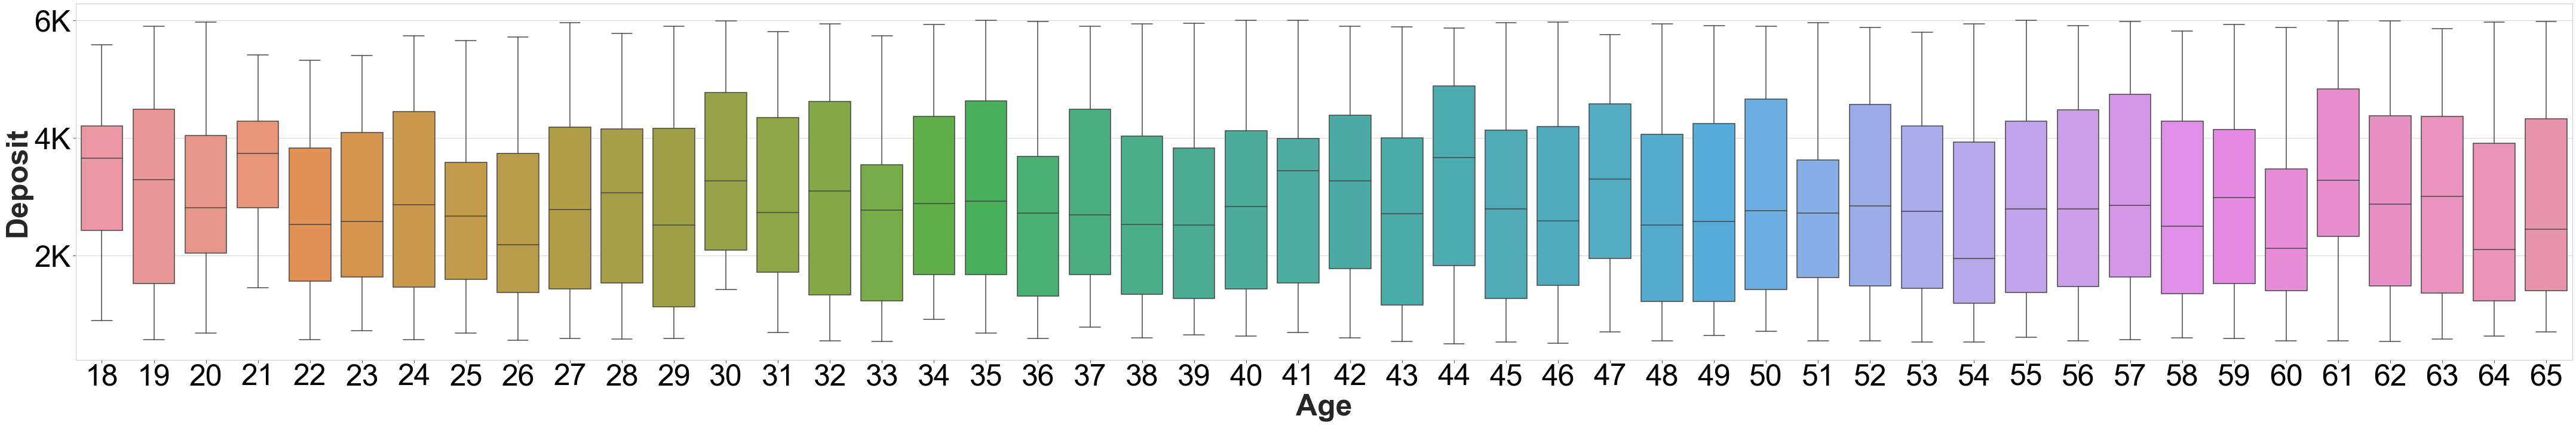

In [70]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, deposit:: NUMERIC
from oodle_data
where application_outcome = 'approved'
and funded = 'Yes'
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='deposit', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('Deposit', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_applicants_approved_funded_deposit_aount.pdf",  bbox_inches="tight")

The figure above shows the distribution of deposits for loans that were <b>approved</b>  and <b>funded</b> across each age

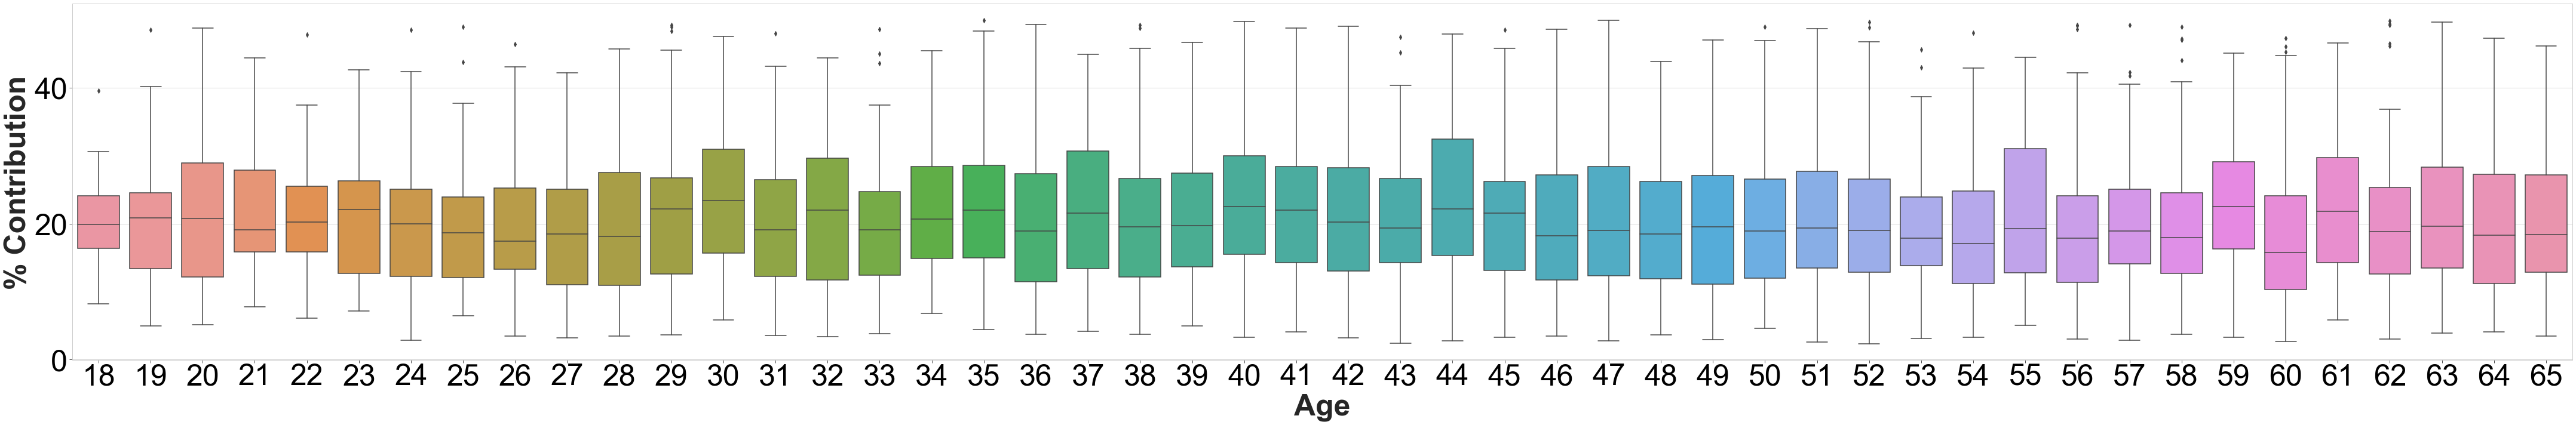

In [72]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, (deposit/(loan_amount + deposit)) *100.0 as percent_contrib
from oodle_data
where application_outcome = 'approved'
and funded = 'Yes'
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='percent_contrib', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('% Contribution', fontsize=50, fontweight="bold")
#ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_applicants_approved_funded_deposit_mount_percent_contrib.pdf",  bbox_inches="tight")

The figure above shows the distibution of the percentage contributed by applicants towards the purchase of a car for <b> approved</b> loans that are <funded> across each age

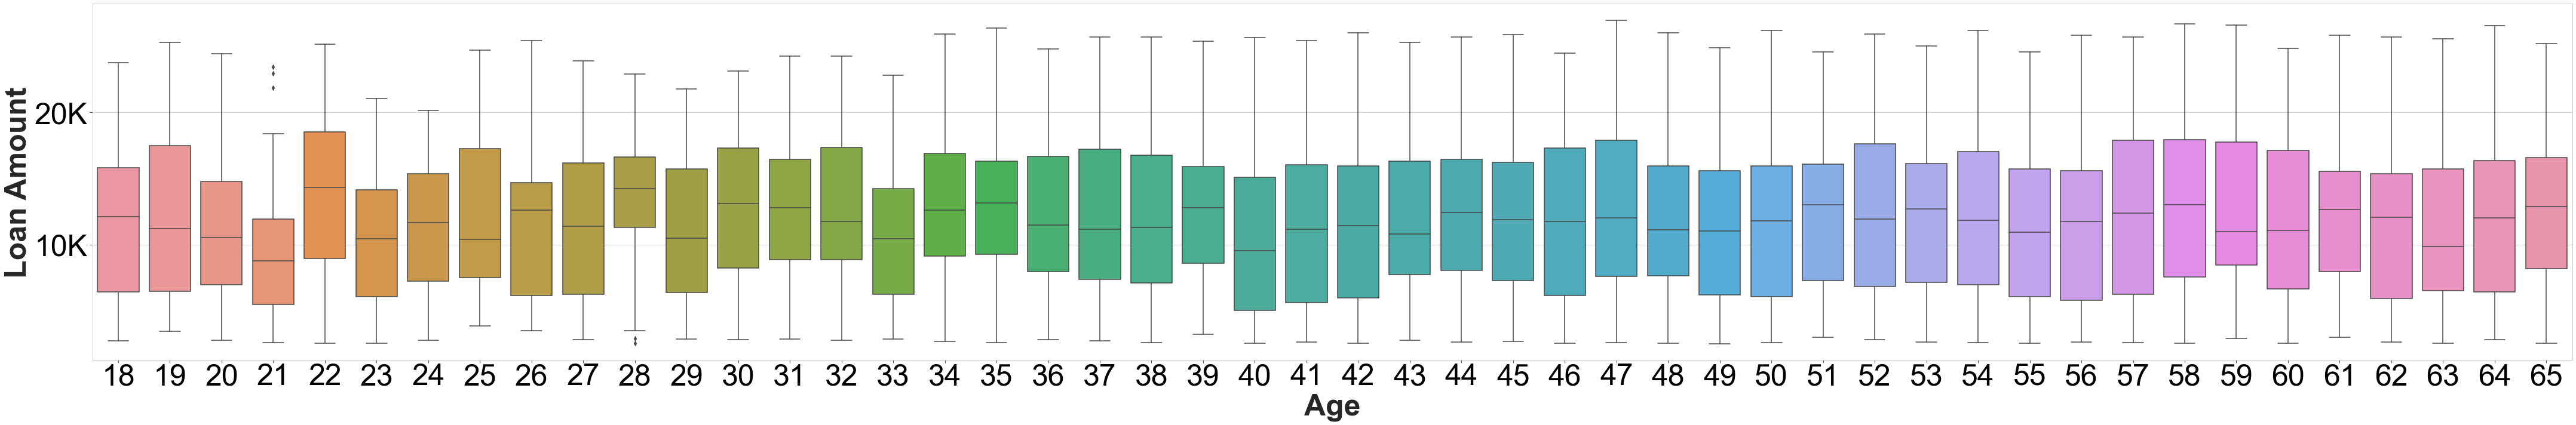

In [66]:
def hundred(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3) 


fig = plt.figure(figsize=(60, 10))  # Create matplotlib figure
ax = fig.add_subplot(111) 

line_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 'black']
plt.style.use('seaborn-whitegrid')



formatter = FuncFormatter(hundred)

sql = """
select age, loan_amount:: NUMERIC
from oodle_data
where application_outcome = 'approved'
and funded = 'No'
"""
df = pd.read_sql(sql, conn)
df['age'] = df['age'].astype(int)
df['age'] = df['age'].astype(str)

#df.boxplot(by ='age', column =['deposit'], grid = False, ax=ax) 
sns.boxplot(x='age', y='loan_amount', data=df, ax=ax)
    
ax.set_xlabel('Age', fontsize=50, fontweight="bold")
ax.set_ylabel('Loan Amount', fontsize=50, fontweight="bold")
ax.yaxis.set_major_formatter(formatter)
ax.get_figure().suptitle('')


ax.tick_params(axis="x", labelsize=50, labelcolor="black", direction="out", length=5, labelrotation=0, pad=0.5)
ax.tick_params(axis="y", labelsize=50, labelcolor="black", direction="out", length=5)

plt.tight_layout()
plt.savefig("figures/loan_amount_applicants_approved_not_funded.pdf",  bbox_inches="tight")

The figure above shows the distribution of loan amounts that was <b>approved</b>  and <b>not funded</b> across each age